<br>
<u>Notebook Sixteen</u> | 
<a href=https://github.com/andrealeone/NLP target=_blank>Repository</a>
<br><br>
<b>Personality Traits</b><br><br>
Andrea Leone<br>
University of Trento<br>
February 2022
<br><br>

In [1]:
import project 

import spacy
import numpy             as np
import pandas            as pd
import sklearn
import sklearn.decomposition
import sklearn.manifold
import sklearn.cluster
import matplotlib
import matplotlib.pyplot as plt
import pickle
import json
import os
import collections

from transformers  import pipeline
from tqdm.notebook import tqdm

In [2]:
records = project.sql_query(""" 
    SELECT * FROM talks
    WHERE transcript IS NOT NULL
    ORDER BY slug ASC;
""")

df = project.create_dataframe_from(records) 

<br>Load BART pre-trained NLI model for zero-shot classification and set up the classification pipeline

In [3]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli") 
classify   = lambda text, traits, ml=True: classifier(text, traits, multi_label=ml)

<br>Organise the personality descriptors for the "Big Five" traits and store traits and indices for the classifier

In [4]:
personality = { 
    #Trait               |  Positive                   |  Negative 
    "openness":          [ "inventive", "curious",       "consistent",  "cautious"  ],
    "conscientiousness": [ "efficient", "organized",     "extravagant", "careless"  ],
    "extraversion":      [ "outgoing",  "energetic",     "solitary",    "reserved"  ],
    "agreeableness":     [ "friendly",  "compassionate", "critical",    "rational"  ],
    "neuroticism":       [ "sensitive", "nervous",       "resilient",   "confident" ]
}

personality_traits = list(personality.keys())
traits = list(); indices = list() 

for trait, values in personality.items():
    traits.extend(values)
    indices.extend([trait]*4)

<br>Set up the logic to tidy the single classification scores, aggregate them, and compute the trait results

In [5]:
def organize_personality_results(classification, put=True, cb=True): 
    
    val = dict( zip( classification["labels"], classification["scores"] ) )
    res = [
        [ indices[traits.index(trait)], trait, score ]
        for trait, score in val.items()
    ]; agg = list()

    for l, ts in personality.items():

        p1, p2, n1, n2 = vs = [ val[t] for t in ts ]

        s = (p1 + p2)/2 - (n1 + n2)/2
        agg.append([ l,  s])

    if put:

        for t1, t2, s in res:
            if s > 0: s = " " + str(s)
            print("{}{} = {}".format(t2.ljust(15, ' '), t1.ljust(20, ' '), s))

        print("")
        for t, s in agg:
            if s > 0: s = " " + str(s)
            print("{}{} = {}".format(
                "".ljust(15, ' '), t.ljust(20, ' '), s
            ))

    if cb:
        return {
            "single":     res,
            "aggregated": agg
        }

<br>Set up the logic to plot the results

In [6]:
def plot_personality_traits_for(results): 
    
    labels, values = project.unzip_array([ 
        [t, s] for t, s in results["aggregated"]
    ])
    
    project.plot_personality_traits_from(labels, values) 

<br>Get a sample transcription

In [7]:
get_text_from_title   = lambda x : df[ df["title"] == x ].iloc[0]["transcript"]

In [8]:
get_text_from_speaker = lambda x,i=0 : df[ df["speaker"] == x ].iloc[i]["transcript"]

In [9]:
text1 = get_text_from_title("Do schools kill creativity?") 
text1[:1011]

"Good morning. How are you?  (Audience) Good.  It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.  (Laughter)  There have been three themes running through the conference, which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here; just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen in terms of the future. No idea how this may play out.  I have an interest in education. Actually, what I find is, everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education -- actually, you're not often at dinner parties, frankly.  (Laughter)  If you work in education, you're not asked.  (Laughter)  And you're never asked back, curiously. That's strange to me. But if you are, and you say to 

<br>Test the model on the sample text

In [10]:
text1_pr = organize_personality_results( 
    classify(text1, traits), put=True, cb=True
)

consistent     openness             =  0.9677838087081909
organized      conscientiousness    =  0.963097095489502
resilient      neuroticism          =  0.9590584635734558
inventive      openness             =  0.9538209438323975
energetic      extraversion         =  0.9451256990432739
outgoing       extraversion         =  0.9366099834442139
compassionate  agreeableness        =  0.9358509182929993
confident      neuroticism          =  0.9322338700294495
curious        openness             =  0.9237435460090637
extravagant    conscientiousness    =  0.9188564419746399
efficient      conscientiousness    =  0.9164766073226929
friendly       agreeableness        =  0.9118326902389526
cautious       openness             =  0.9041724801063538
rational       agreeableness        =  0.8886380791664124
reserved       extraversion         =  0.8660832643508911
critical       agreeableness        =  0.8450542688369751
sensitive      neuroticism          =  0.7770594954490662
careless       

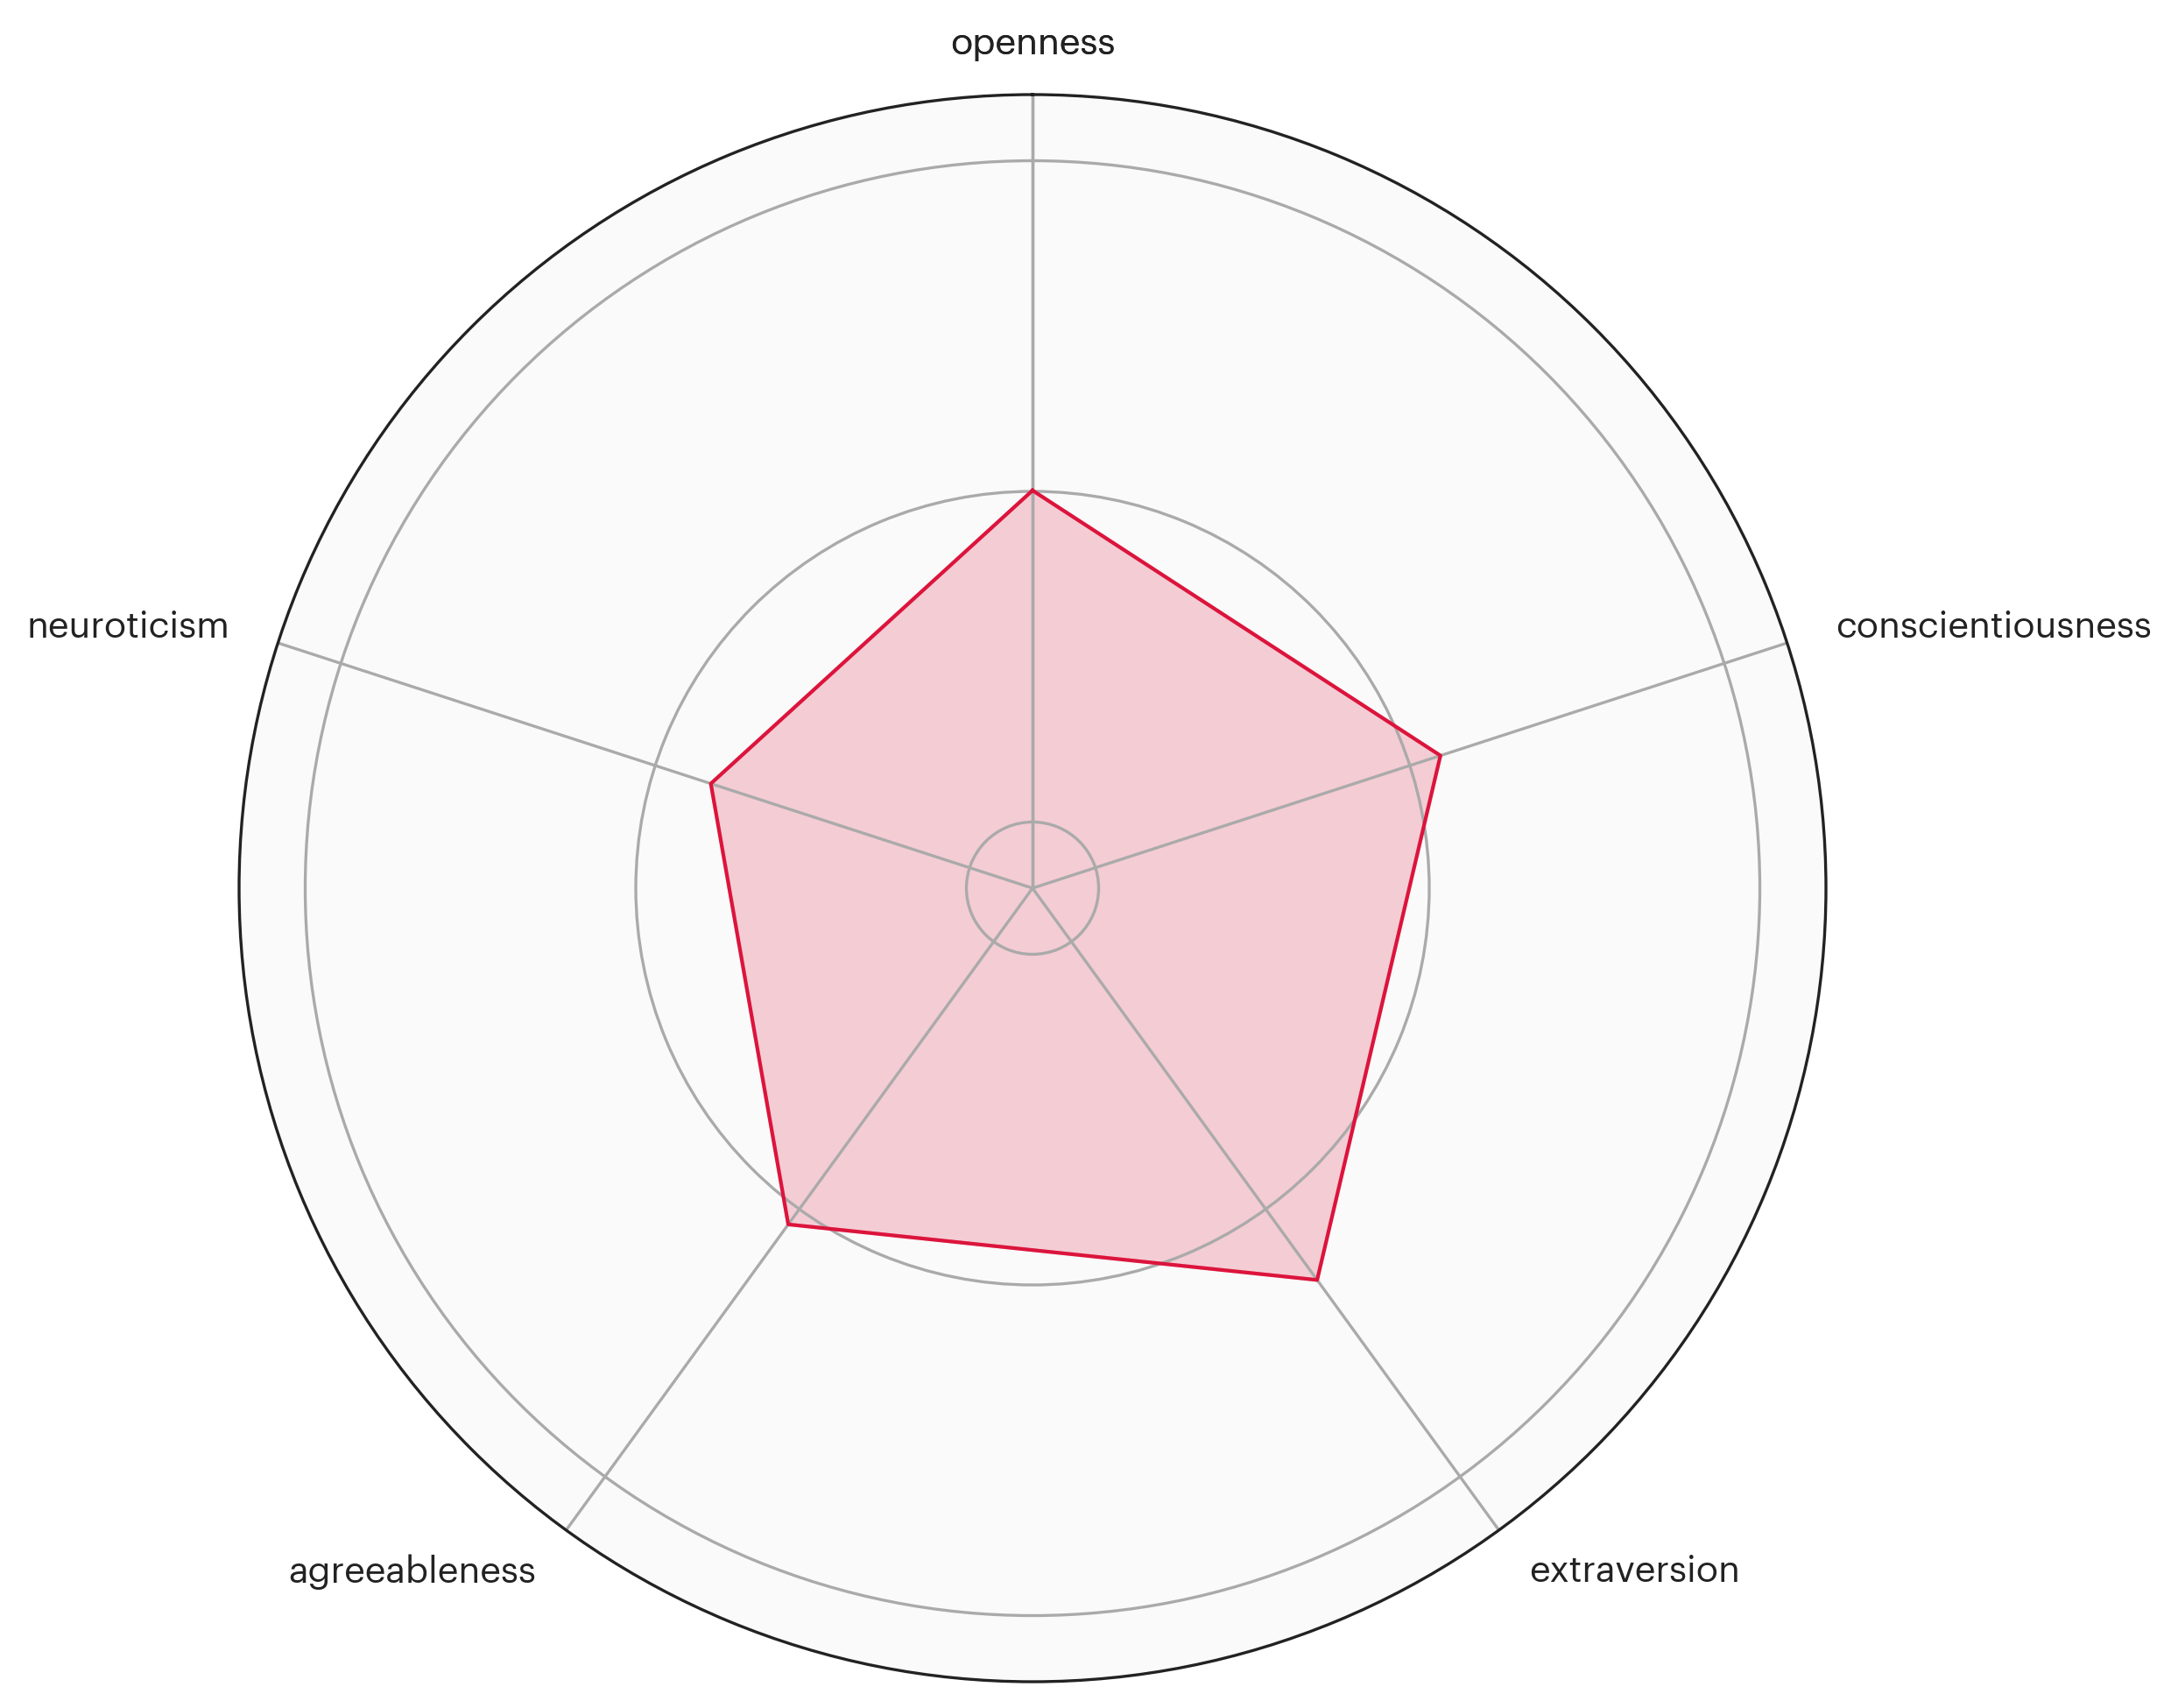

In [11]:
plot_personality_traits_for(text1_pr) 

<br>Test on a couple of blog posts of David Heinemeier Hansson

confident      neuroticism          =  0.9722539186477661
energetic      extraversion         =  0.957532525062561
organized      conscientiousness    =  0.9519182443618774
inventive      openness             =  0.9466274976730347
efficient      conscientiousness    =  0.9462306499481201
compassionate  agreeableness        =  0.939995288848877
consistent     openness             =  0.9392072558403015
extravagant    conscientiousness    =  0.9347233176231384
rational       agreeableness        =  0.9318809509277344
resilient      neuroticism          =  0.9285014271736145
critical       agreeableness        =  0.9213125109672546
friendly       agreeableness        =  0.9172199368476868
outgoing       extraversion         =  0.8801723122596741
curious        openness             =  0.8767043948173523
sensitive      neuroticism          =  0.8427398204803467
reserved       extraversion         =  0.8370275497436523
cautious       openness             =  0.7880843877792358
solitary       e

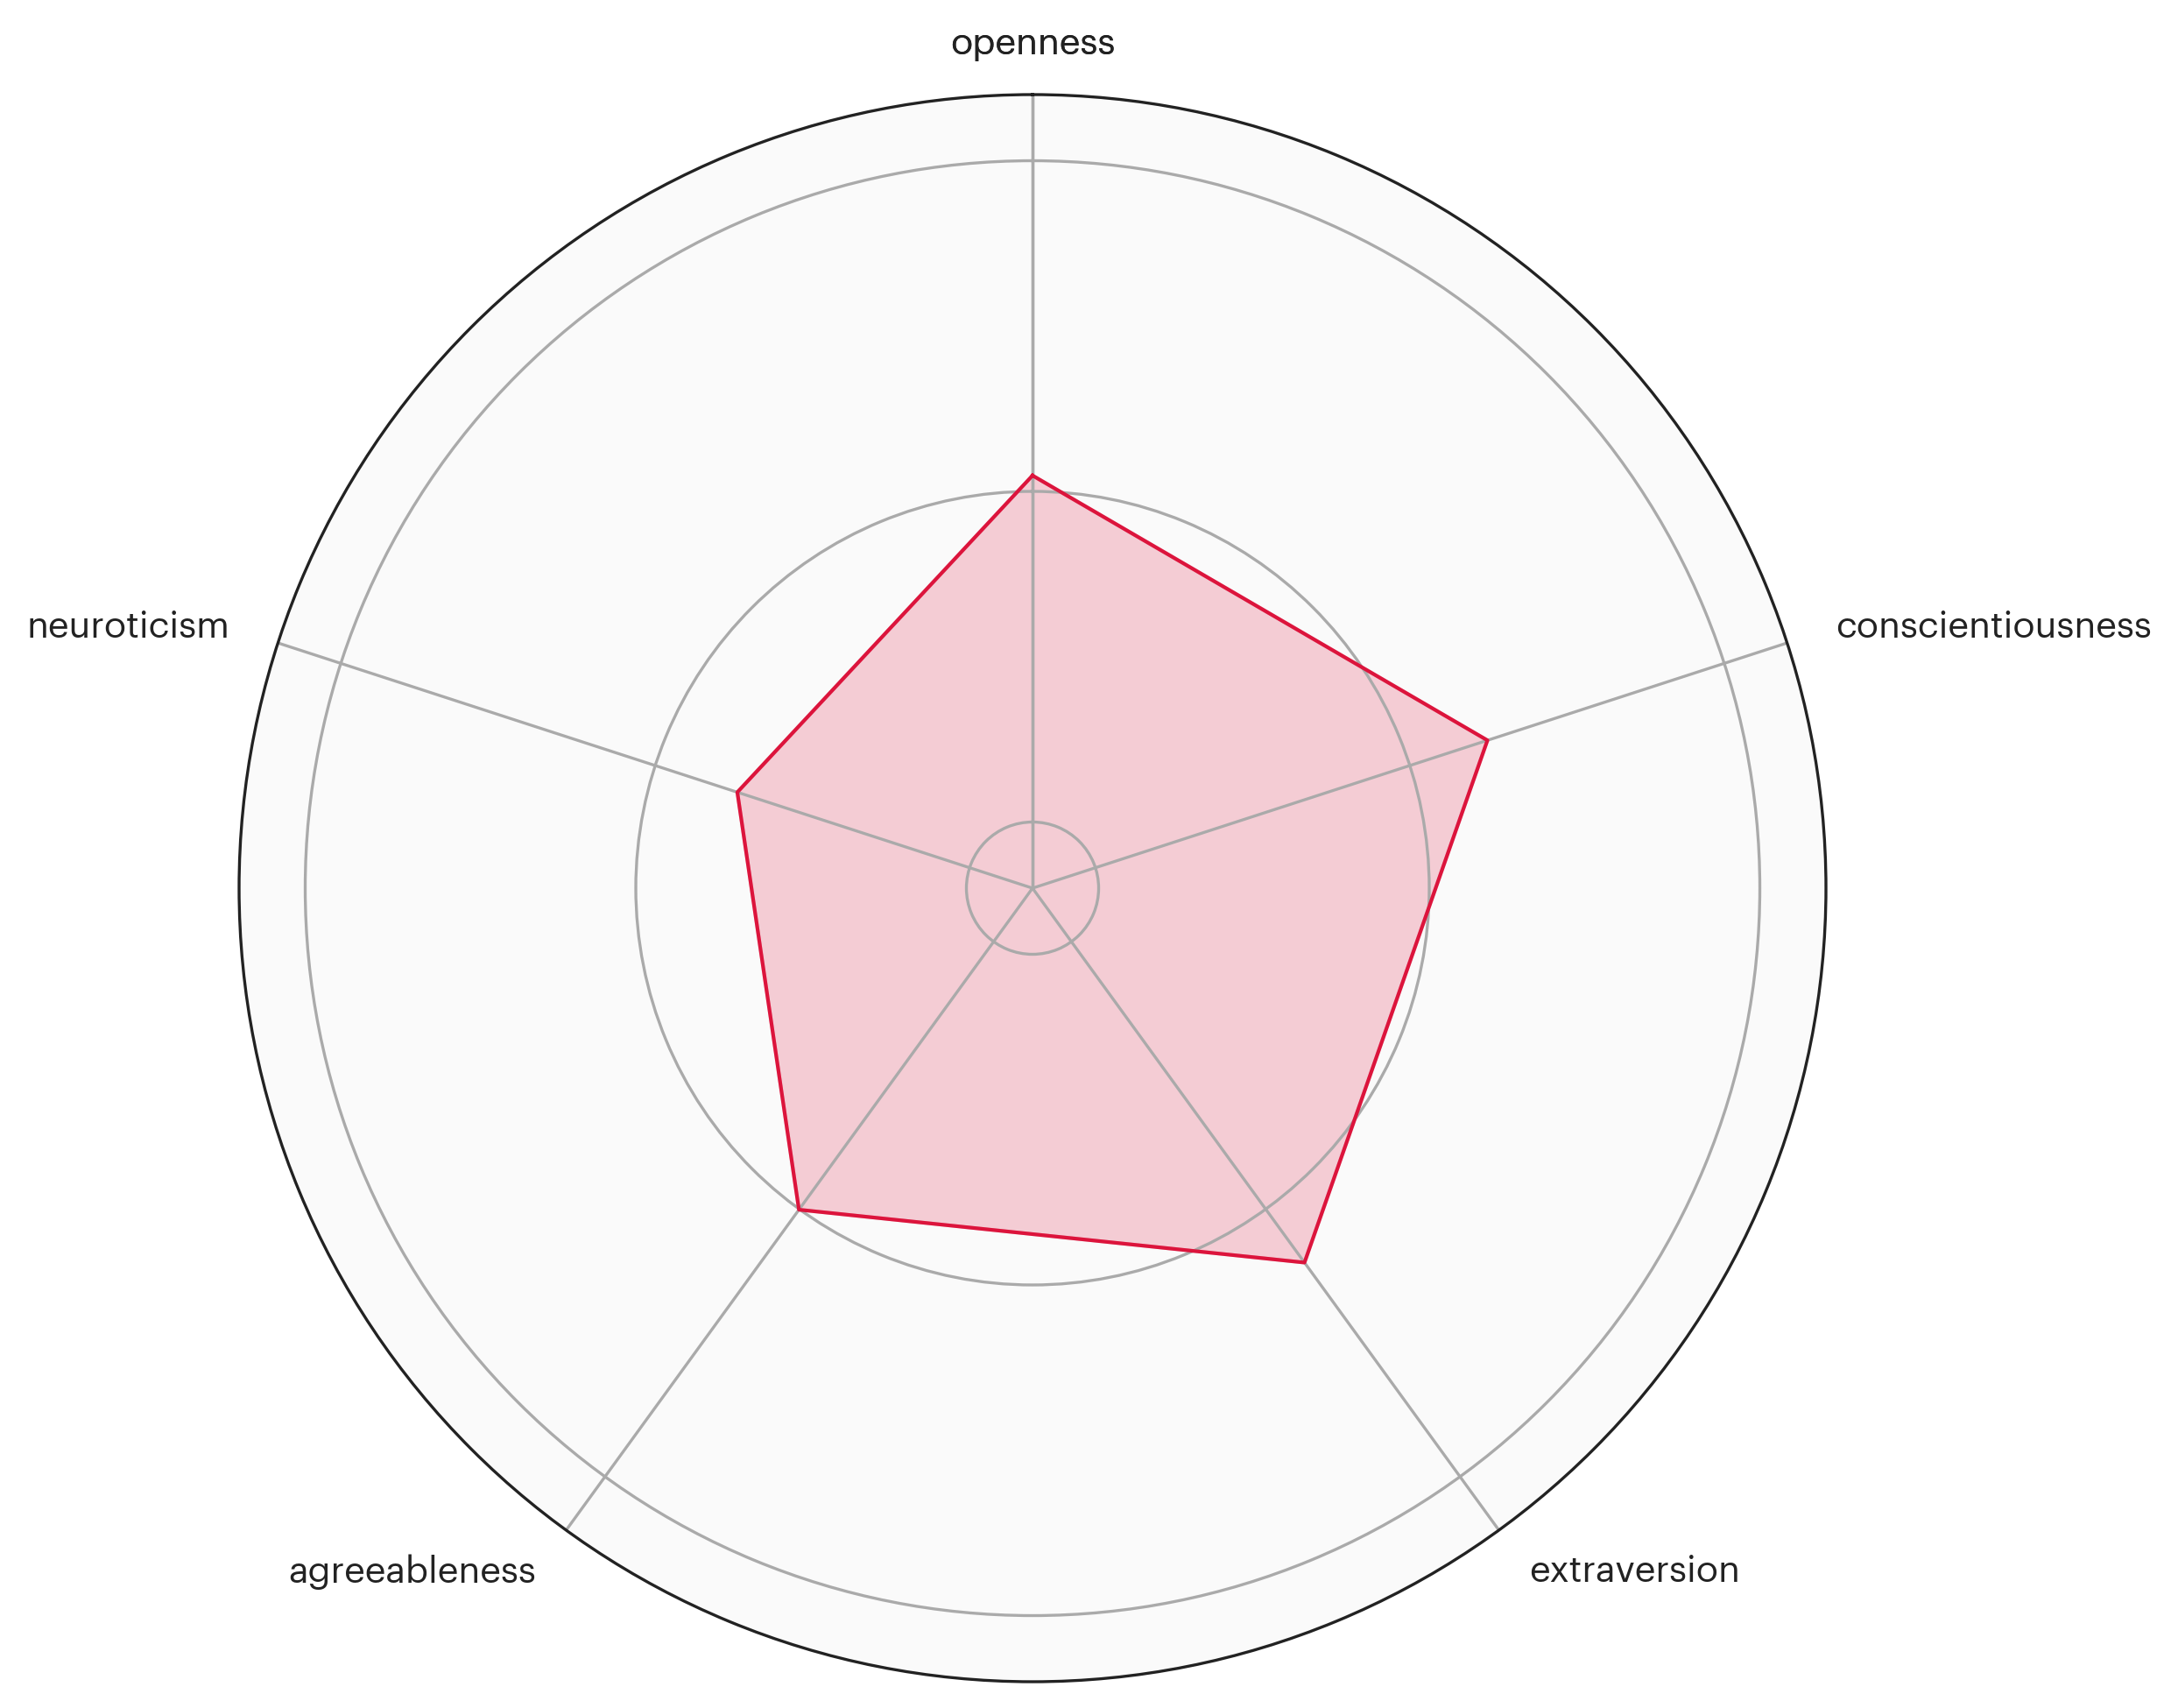

In [12]:
dhh_post1 = """
2021 was an incredible year for Ruby on Rails. We started it off still celebrating the third major version of Ruby, and left it with the accomplishment of the seventh major version of Rails. Together, these releases sparked a renewed enthusiasm for building modern web applications with Ruby on Rails, unlike anything I can recall since the late oughts. The moment was finally right, and we were right for the moment.
I spent most of my time last year advancing the new vision of Rails on the frontend with a slew of projects. The biggest lift was getting the dream of a Node-free default Rails approach validated, solidified, and production ready. 
I worked to make that happen by creating importmap-rails, and by taking HEY to this new frontier as a confirmation that we'd crossed the chasm from vision to reality. Collaborating with Guy Bedford on his crucial enabling work with es-module-shims.
As a result, we really did manage to dramatically compress the complexity of both getting started with Rails, and making those high-fidelity apps that rely on modern JavaScript.
This happened concurrently with the effort to have Rails adopt Hotwire as a replacement for the old Turbolinks and Rails UJS combo. Giving every new Rails app the power of Turbo 7 and Stimulus 3 as standard, without having to deal with a node_modules directory of thousands of dependencies or webpack configurations up the wazoo. I built turbo-rails and stimulus-rails to make the integration seamless with the JavaScript frameworks we'd spent years developing at Basecamp.
Between getting rid of Node, forging a part with import maps, and committing to Hotwire, the default frontend story for Rails became complete and compelling unlike anything we've ever had before. No more excuses or apologies for the rabbit hole that Webpacker could often be or the limitations of Sprockets.
While this new, daring default path for Rails 7 turned out to be a bull's eye hit, I'm almost as proud of the improvements to the alternate route as well. There are many reasons why someone would want to embrace Node, transpiling, bundling, and the rest of the complexities inherent with the traditional JavaScript path. Whether that be because the entire UI is written in React, Vue, or whatever, this approach isn't going anywhere, and Rails should have first-class affordances. Now it does!
With jsbundling-rails, I created a bridge between a fully "native" JavaScript experience and our Rails asset pipeline. Free from being hardcoded to webpack and a particular configuration of that, Rails 7 has made it trivial to use all of the major bundlers, including esbuild and rollup.js. But perhaps in particular esbuild, which has emerged as the most promising solution with incredibly fast compilation and simpler configuration.
I then followed the crumbs of compression from jsbundling-rails and created cssbundling-rails. Which leaned on the same insights and simplifications to make integrating with Tailwind CSS, Bootstrap, PostCSS, and Dart Sass a turn-key operation. Embracing the fact that many of these modern CSS frameworks require a full JavaScript setup for detailed configuration and integration.
So whether you want to go Node-less, full Node, or no front-end inside the Rails app at all, we now have stellar answers for every choice. That's a big tent! Which means that more people in more situations can enjoy and collaborate on the parts of Rails that we all love and share. Active Records and Action Controllers pair perfectly with all the options.
As if that wasn't enough, I was really happy to finally crack the nut of a proper Redis abstraction in Rails together with Kasper Timm Hansen. We've been using Redis for a very long time at Basecamp, but always at a surprisingly low level. Then suddenly, emerging from the work we'd done in HEY and Basecamp, the right abstraction appeared, and the result became Kredis. Now an official second-party framework to Rails, and suggested in the default Gemfile.
To properly commemorate all this delightful progress, as well as capture the energy and enthusiasm of the reception, I worked with our new designer Sean Mitchell at Basecamp to create the first new Rails site in six years. With a fresh identity, bootscreen, and introduction video. It looks great, and perfectly capped off this monumental effort to set Rails on a new course.
And these are just the projects and improvements that hit primetime in 2021! I also spent the year charting a direction for compounding compressions to come in Rails 8, and beyond. 
Our trusted asset pipeline, Sprockets, has been long in the tooth, underdeveloped, and overcomplicated for our needs today for too long. To remedy that for tomorrow, I created Propshaft as a clean-sheet implementation of an asset pipeline built for the challenges we face in 2021+. And then worked with Breno Gazzola to make that production ready faster than I had imagined (we're already running on Propshaft in production with HEY!).
This led directly to the development of tailwindcss-rails and dartsass-rails. Two wrap-the-standalone-executables gems that make using the full power of Tailwind CSS and Dart Sass possible with a Node-less application, and specifically designed for Propshaft (since it doesn't have a built-in Sass compiler, unlike Sprockets). Mike Dalessio was instrumental in setting up the gem-by-platform encapsulation, and I can't thank Adam Wathan and the Tailwind team enough for heeding my pleas to wrap Tailwind CSS 3 as standalone version we wouldn't need Node for.
While these developments are already suitable for those who enjoy life at the frontier, I'm even more excited to get them to a place where they can become stronger, perhaps default, recommendations going forward. But that's chatter for a Rails 7.next or Rails 8 discussion. Point is that all of this was conceived, coordinated, and built in 2021. What. A. Year.
So imagine my surprise when I got this email from the folks at Ruby Central, who've been organizing RailsConf, the conference I helped kick off in 2006:
It's a real shame that this is the world we find ourselves in now. One so sharply divided by politics and ideology that we can't even share the love of Ruby on Rails together at a conference without a need to settle scores.
But I guess it shouldn't come as a surprise. The way the debacle around the announced web3 track at RailsConf was handled was just one illustration that this is where we are now. That an interest in learning and exploring new technologies first need to pass a partisan filter, and if it doesn't, there's hell to pay and groveling apologies to be made. No matter whether that's a space that has activity from some of the largest Rails apps and employers.
What does "you having been mostly offline the last year" even mean? Is there a pious tweet minimum? What does that have to be with being "impactful" with the work? I know, trying to deduce an inner logic of an obvious pretext is a fool's errand.
But it also casts an unfortunate shadow of uncertainty over the whole event. Should companies that support RailsConf by sending employees, speakers, or sponsorship money expect retaliation or exclusion if they end up transgressing against whatever shrinking ideological ring surround the organizers or program committee?
Would GitHub have faced such retaliation if the ICE controversy had broken today? Would Shopify employees have been denied stage time if the Breitbart issue had happened now? Is a company like Coinbase or Block or even Shopify welcome at all given their involvement with crypto and web3?
Either way, while it's a shame that the organizers and program committee for RailsConf have chosen this path, it's not going to dim my enthusiasm for Ruby on Rails and our bright future in the slightest. There's so much exciting energy right now, and I have more motivation for pushing our framework forward than I've had in many years. I'll be thrilled to share my yearly keynote with everyone either at another in-person conference this year or online.
With close to twenty years of involvement in this community, I'm confident we'll be able to eventually route around the fractious politicization that's been leaking into our proceedings. I don't believe that this is what most programmers or most companies ultimately want. But it's a perilous time to reveal preferences, so I fully understand why many choose to duck instead.
For me, this work has always been a labor of love. It's so gratifying to see new programmers realize what they can build, and existing Ruby on Rails companies reach the skies. Nothing can detract from that. Cheers to another two decades and beyond of open source collaboration, beautiful code, and happy programmers!
""" # https://world.hey.com/dhh/no-railsconf-faa7935e

dhh_p1 = organize_personality_results( classify(dhh_post1, traits) ) 

plot_personality_traits_for(dhh_p1) 

sensitive      neuroticism          =  0.8943067789077759
curious        openness             =  0.8608134984970093
critical       agreeableness        =  0.8583415746688843
energetic      extraversion         =  0.7708667516708374
organized      conscientiousness    =  0.7534377574920654
efficient      conscientiousness    =  0.7398764491081238
cautious       openness             =  0.7334727644920349
inventive      openness             =  0.6256263852119446
consistent     openness             =  0.5657897591590881
extravagant    conscientiousness    =  0.5113335251808167
nervous        neuroticism          =  0.4678323566913605
reserved       extraversion         =  0.4364181160926819
outgoing       extraversion         =  0.38495275378227234
resilient      neuroticism          =  0.3571329414844513
careless       conscientiousness    =  0.3357257843017578
compassionate  agreeableness        =  0.29648301005363464
solitary       extraversion         =  0.28448909521102905
rational   

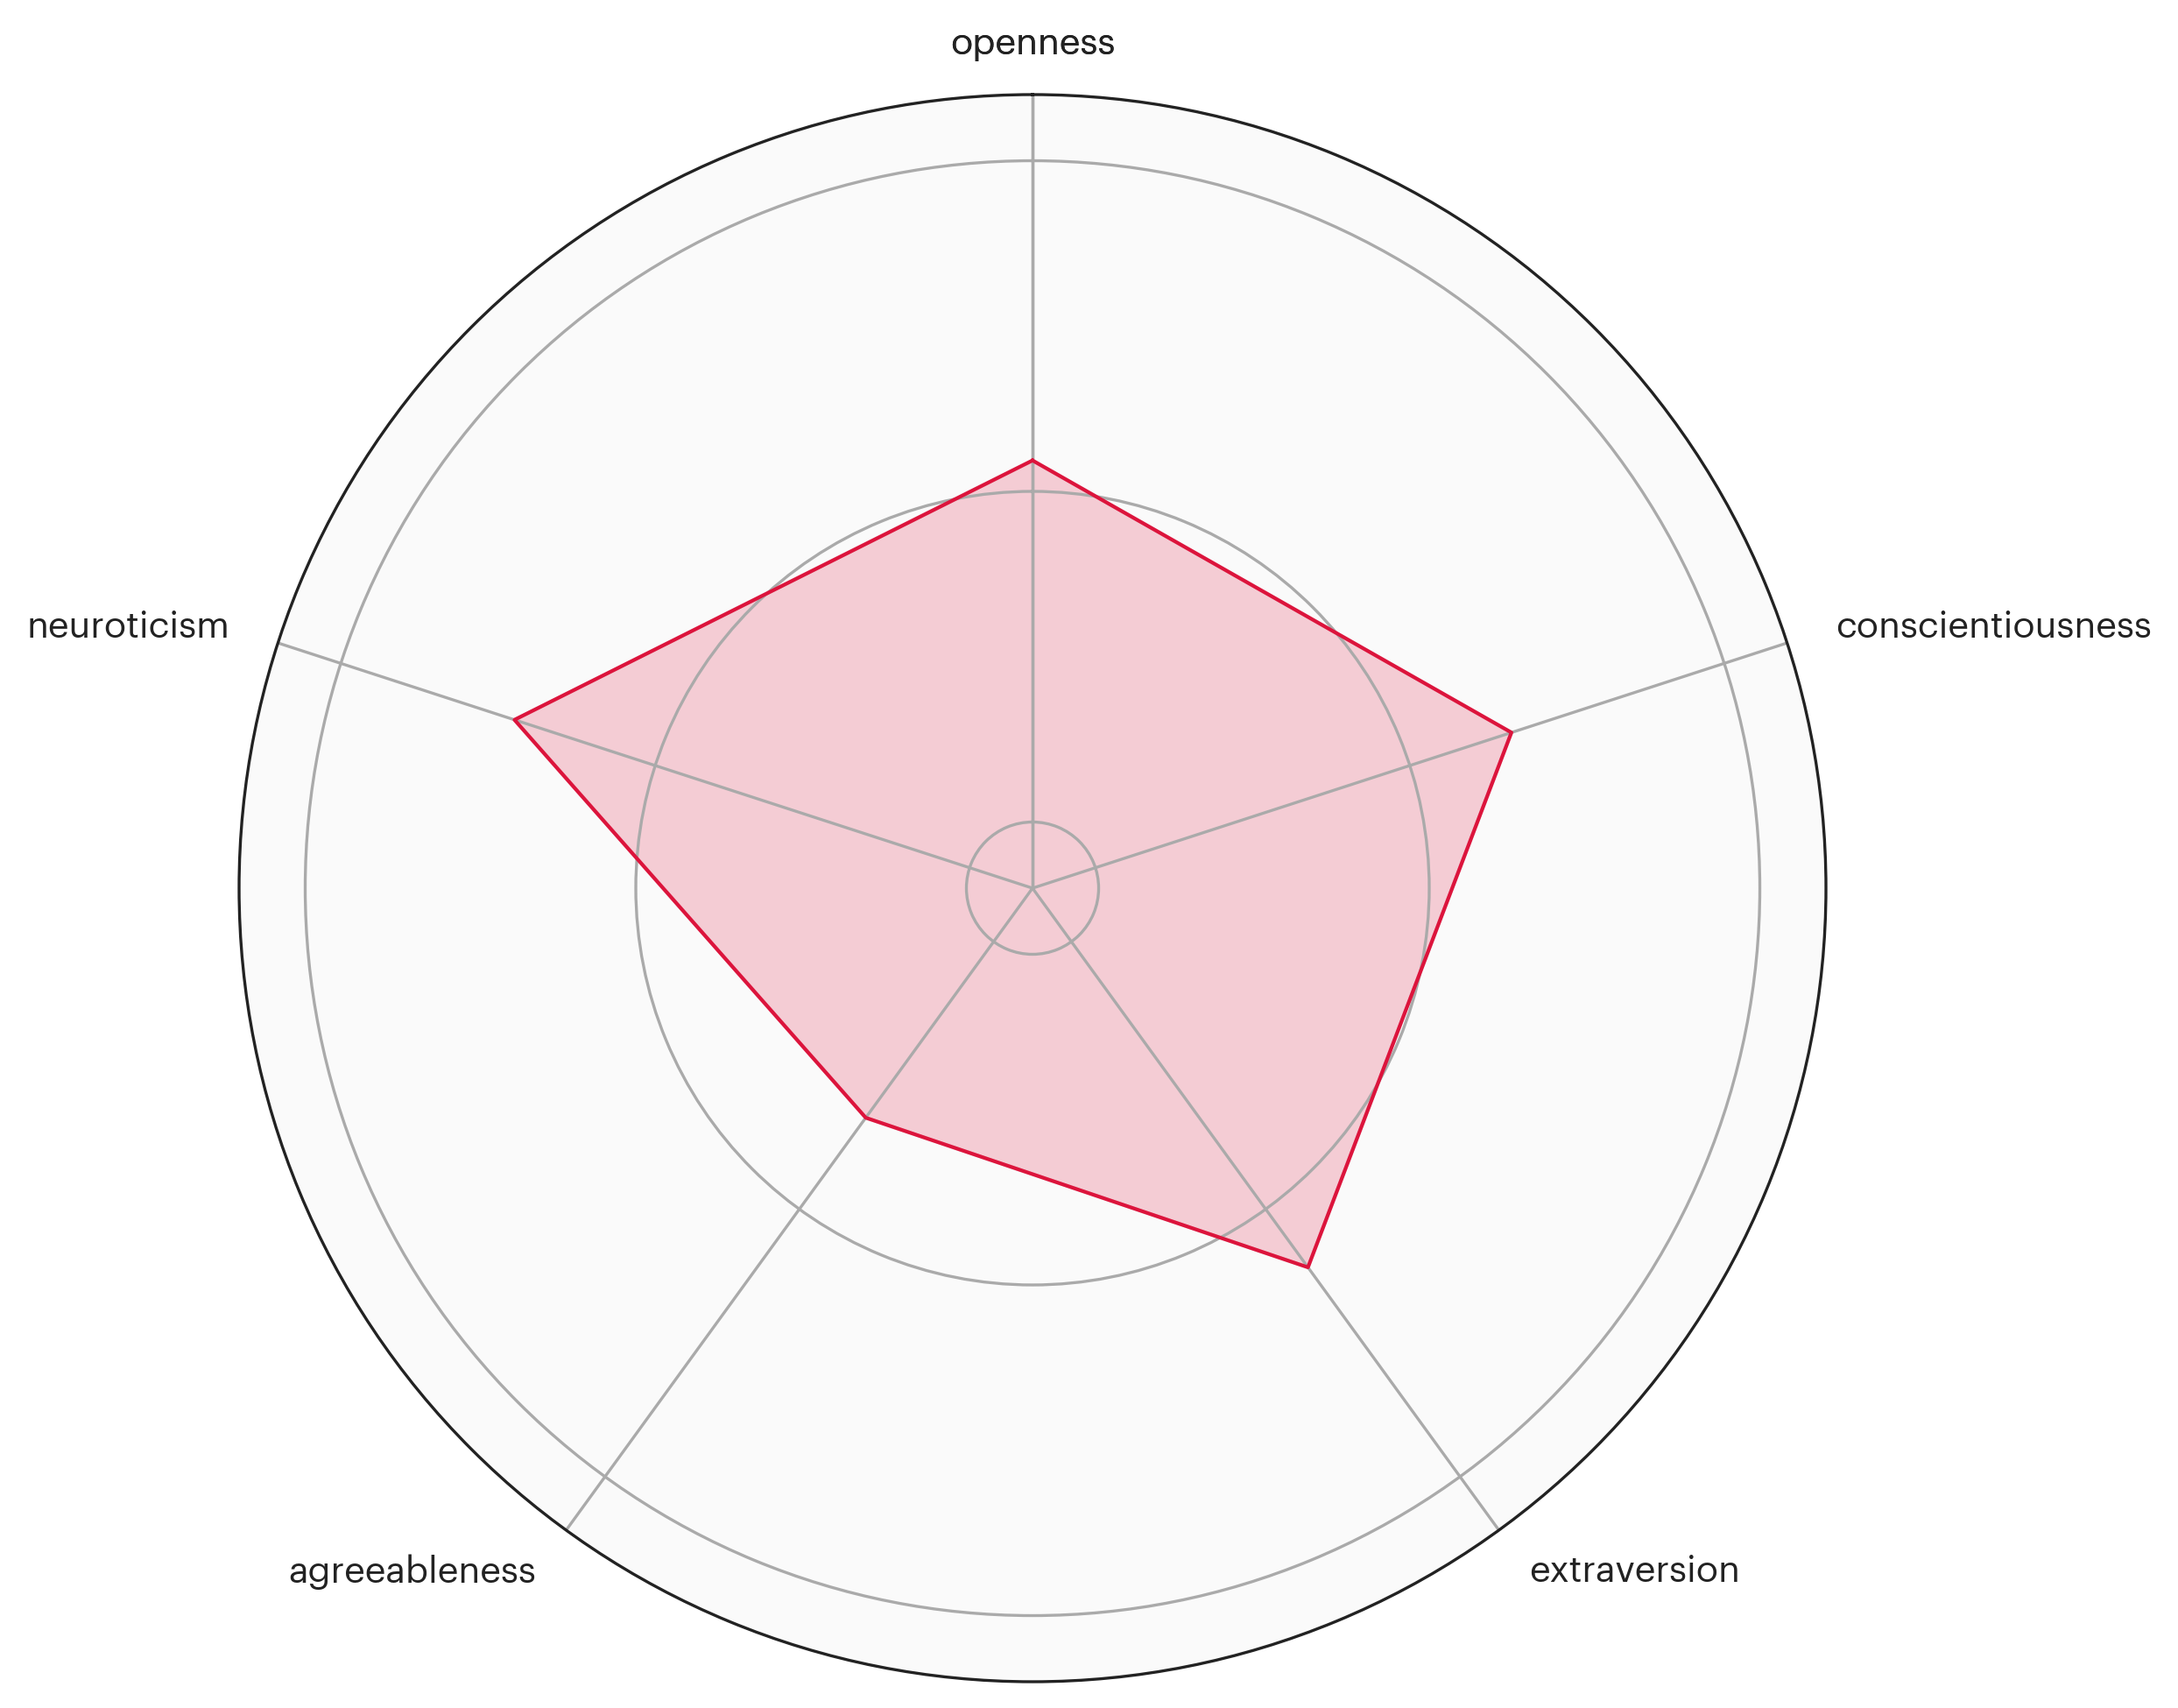

In [13]:
dhh_post2 = """
One of the most compelling metaphors of the battle between emotion and reason is that of the elephant and the rider. I first encountered it in Jonathan Haidt's book The Righteous Mind. It goes like this:
It's the same underlying premise to Julia Galaef's book The Scout Mindset. We launder our arguments and reasoning through the tribal wash. Which is made easier by the fact that many valiant principles are in opposition to each other, and that you can often conveniently lean on the ones that serve the moment and your tribe. Without even consciously being aware of this process of motivated reasoning.
But I think we're unconsciously very aware, actually. Which is why it often appears that the most infuriating, polarizing figures are those who do not succumb to this tribal-first reasoning. They mere being insert a splinter in the minds of those embracing the tribal stance – i.e. most people – that living closer to universal principles is possible.
In my book, one of the best examples of this is Glenn Greenwald. He used to be a hero of the left when he was haunting the Bush administration during the early Iraq War years. But slowly, then all at once, fell out of favor when he applied the same principles of inquiry to first the Obama administration, then later to Hillary and the loss to Trump.
The same principles that drew applause when they were directed against the right suddenly invoked the most indignant contempt when they were applied to the left. And it cut both ways! Those on the right who would have had no bones calling him a traitor during the Bush years now happily embraced his inquiries during the Obama years and today.
It didn't even matter to many that he broke several of the biggest stories of our time. Like the Snowden revelations and the Brazilian corruption scandals. The fact that he applied universal principles caused such severe cognitive-dissonance hangovers amongst former supporters that he now seemed worse than even the other side. He became a traitor to the team.
But what perhaps impresses me the most about Greenwald's continued quest for universal principles is his seemingly unlimited faith in the possibility of a world that could be governed by such high-minded ideals. Despite the recurring evidence to the contrary. Despite the torrent of insults and jeers that meets his repeated attempts at applying such principles.
The world needs unreasonably reasonable people. To give us hope that principles can serve a higher cause, not just be used to score partisan points. Even if I'm probably more convinced than ever that Haidt's metaphor simply is the base nature of humanity. That we're hard-wired to be of weak principles and strong tribal allegiance.
It's unlikely that we'll suddenly all become perfect scouts through intellectual role modeling, but minting more scouts with stronger allegiance to universal principles is still a noble cause.
""" # https://world.hey.com/dhh/weak-principles-strong-tribes-fead41e9

dhh_p2 = organize_personality_results( classify(dhh_post2, traits) ) 

plot_personality_traits_for(dhh_p2)

<br>Test on the YouTube transcripts of ArkInvest's Cathie Wood podcast

organized      conscientiousness    =  0.9135423898696899
critical       agreeableness        =  0.8909254670143127
inventive      openness             =  0.8623014688491821
sensitive      neuroticism          =  0.8463342189788818
energetic      extraversion         =  0.8384077548980713
efficient      conscientiousness    =  0.8320323824882507
rational       agreeableness        =  0.8283263444900513
compassionate  agreeableness        =  0.8179700374603271
confident      neuroticism          =  0.7933172583580017
outgoing       extraversion         =  0.7695116400718689
cautious       openness             =  0.7606478929519653
extravagant    conscientiousness    =  0.7580338716506958
consistent     openness             =  0.7443052530288696
curious        openness             =  0.7423408627510071
resilient      neuroticism          =  0.6729620099067688
nervous        neuroticism          =  0.6684943437576294
reserved       extraversion         =  0.6635165214538574
careless      

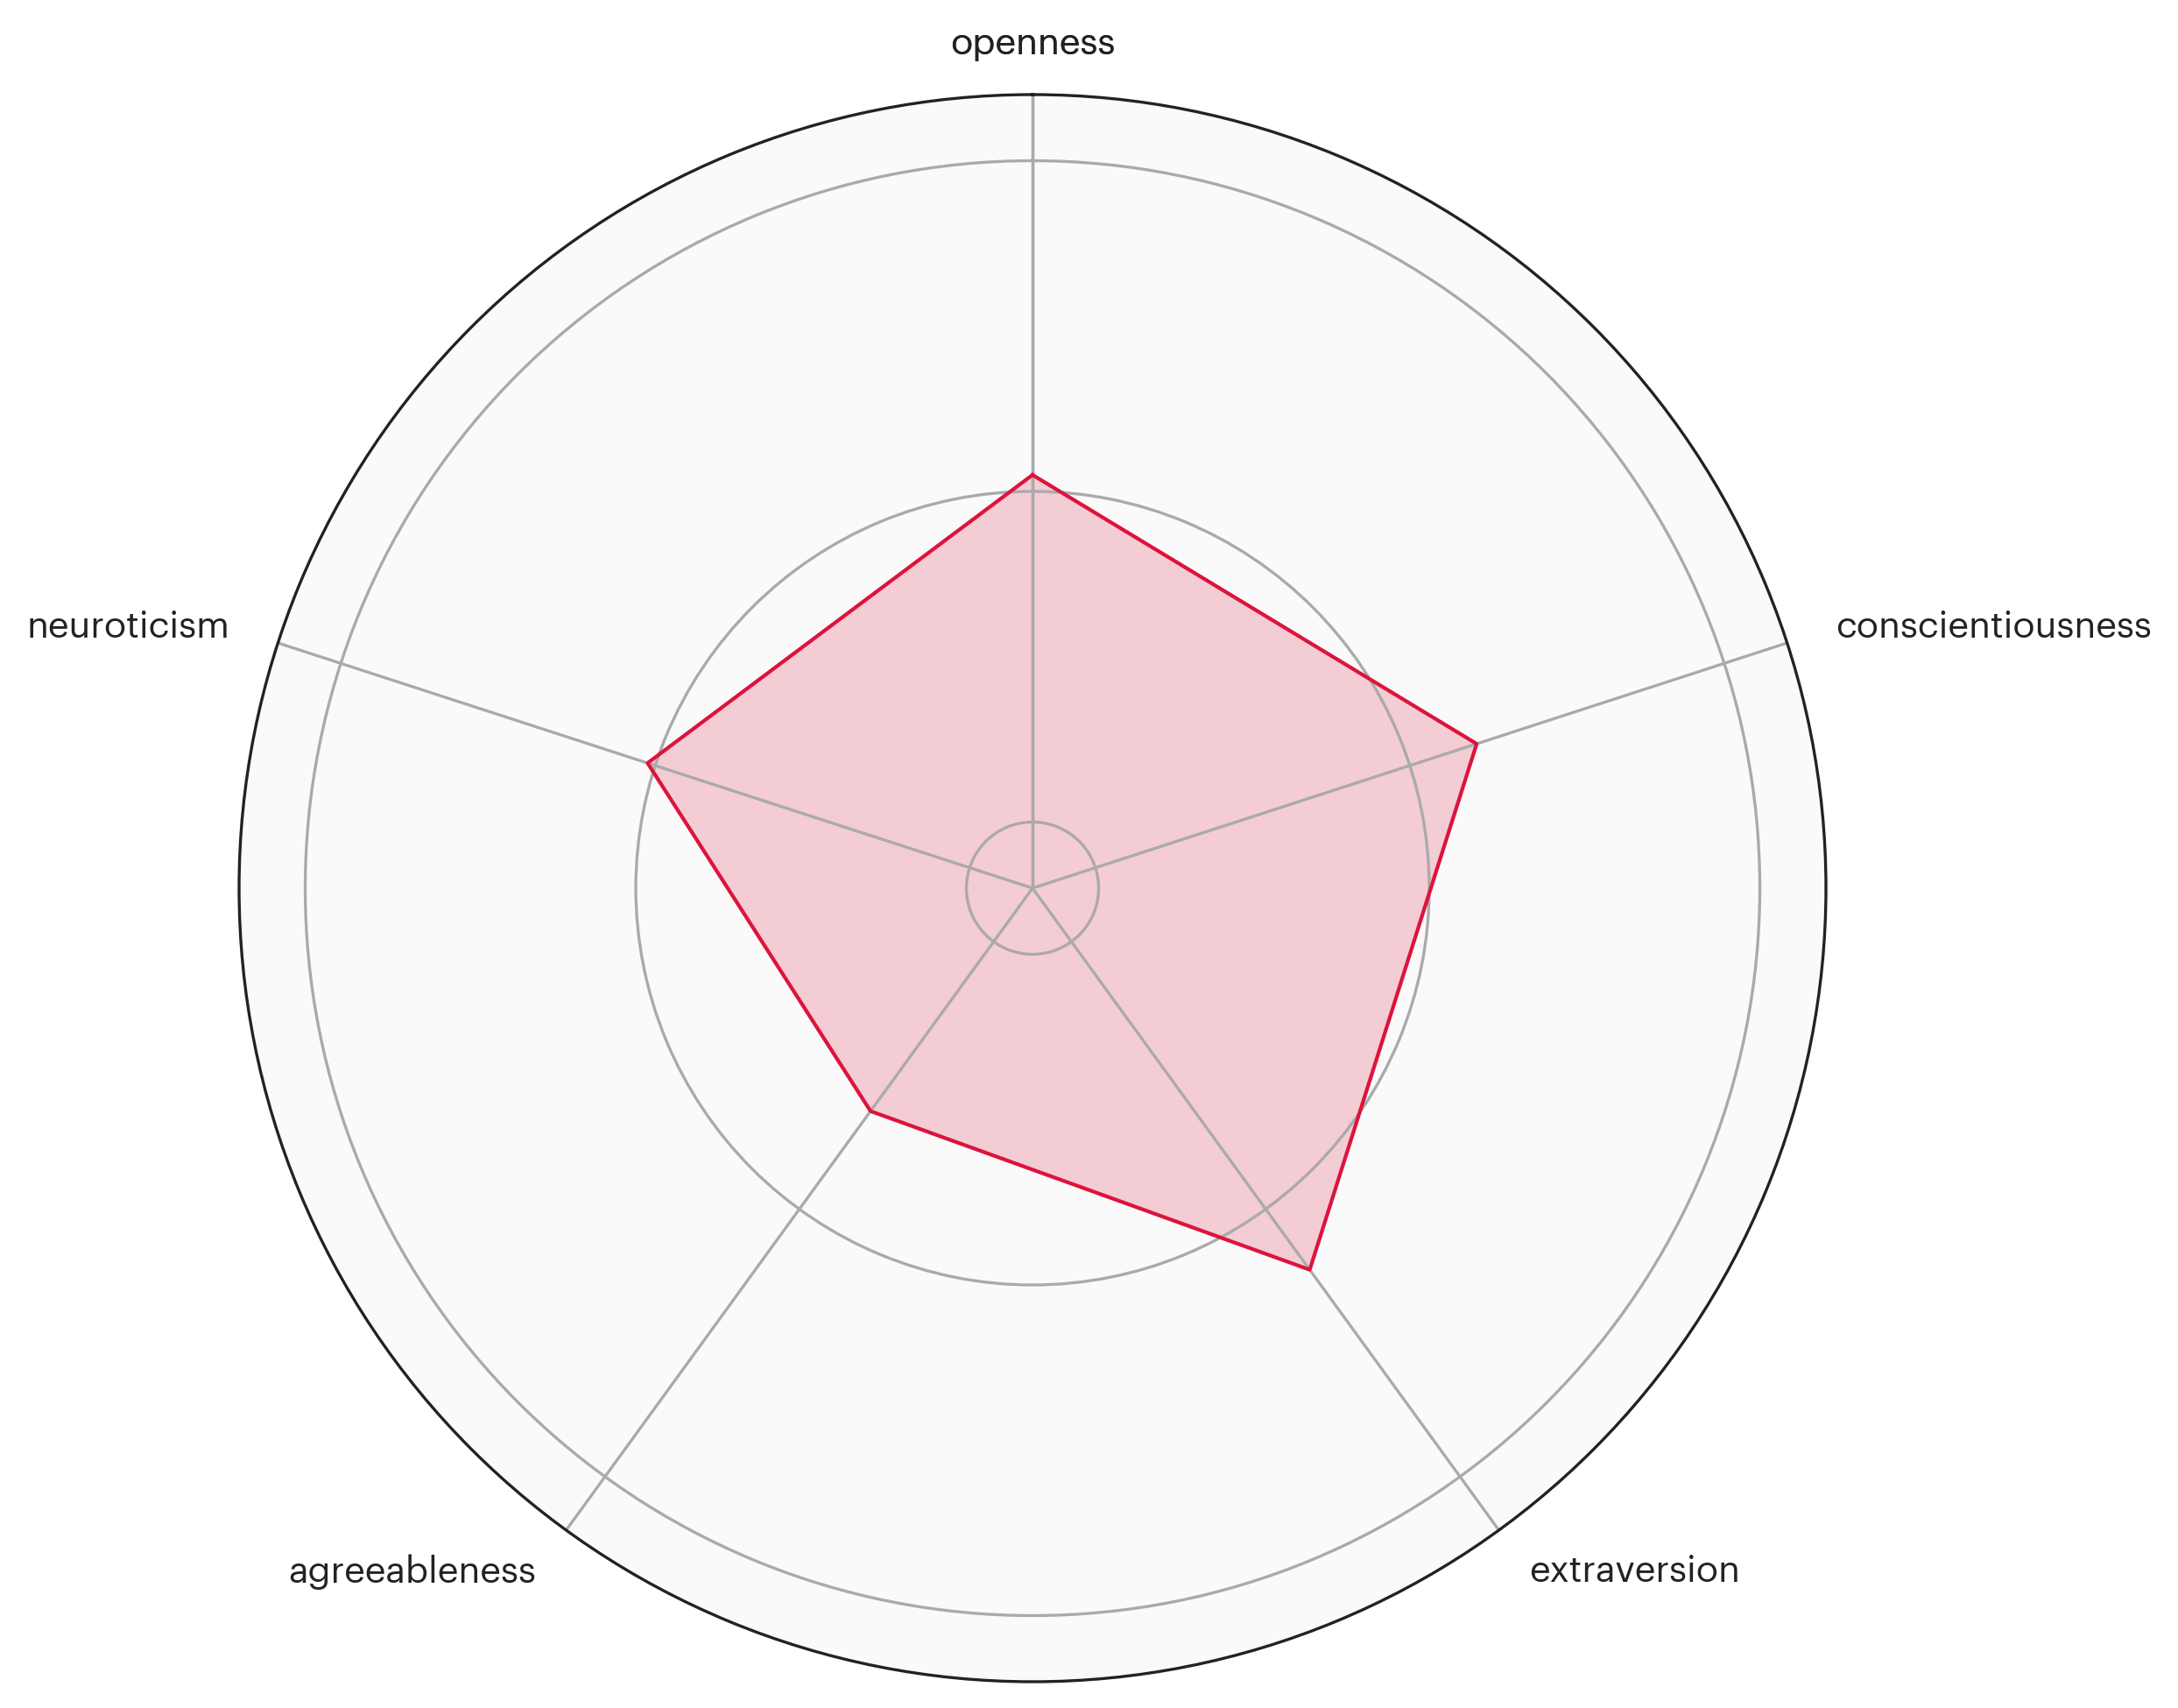

In [14]:
cw_talk1 = """ 
greetings everyone it's employment friday so uh i'm kathy wood uh from arkhamvest uh you for the usual fiscal policy\nmonetary policy economic indicators\nmarket indicators and a little bit about\ndisruptive innovation\nwell let's start actually with\ndisruptive innovation disruptive\ninnovation\nis inherently controversial\nand tends to be quite a volatile\nstrategy\nif you have a long-term investment\nhorizon which you have to when you're\ninvesting in disruptive innovation\nthings tend to work\nout and i'm not really saying anything\nabout the future can't make any\nguarantees however\nif you look at\nthe five-year track record of our\nstrategies including\nthe significant volatility we've seen in\nthe last year uh you will see\nnumbers that i would put against to any\nother uh active management strategy out\nthere we have outpaced outperformed\nthe broad-based benchmarks whether\nyou're talking about the s p\nmorgan stanley\nmsei world\nor the nasdaq\nand\nand as i understand it most active\nmanagers have not\nin fact the vast majority of active\nmanagers have not\nand so yes we do go through periods of\nsignificant volatility\nbut\nas we also say if we've done our\nresearch correctly around wright's law\nunderstanding learning curves cost curve\ndeclines and understanding the price\nelasticity of demand\nour companies are usually rewarded for\ntheir breakthrough technologies that are\ntransformational\nin terms of changing the way the world\nworks\nand\nour conviction in\nour our research has only grown if\nanything\nduring the last two years\nwe have\nwatched\nour research point to\nan expansion in the market cap\nopportunity associated with disruptive\ninnovation\nfrom 75 trillion dollars which is which\nwas our five-year expectation two years\nago\nto 210 trillion dollars with artificial\nintelligence being\nprobably the biggest reason\nso we're very excited about what's going\non\nthe momentum is in place the valuations\nof the stocks in the public equity\nmarkets associated with disruptive\ninnovation have been crushed in the last\nyear\nbut if you look at the private markets\nthose valuations have not been crushed\nif anything we've seen\nan escalation\nso there's a disconnect here and we\nthink that the private markets are on to\nsomething and as i just mentioned\nour our research is pointing to bigger\nand bigger opportunities as the five\nmajor platforms around which we have\nbased our research and investing as they\nall scale exponentially and converge one\nfeeding the other\nso\ni'd also like to talk about disruptive\ninnovation in the context of the\nfinancial services industry\ni believe that arc has become a source\nof disruptive innovation in the\nfinancial services industry\nwe are index agnostic we do not let\nan index serve as a screen\nfor our portfolios we don't think that's\nthe right way to look at the future\nthe indexes are all about the past\nso we are index agnostic and the screen\nfor our portfolios is our research\nwhen i started in the business\nmany years ago\nthe screen for portfolios was research\nreal original research\nwe give away our research we share our\nresearch we're the first sharing economy\ncompany in the asset management\nworld\nand as you know in the sharing economy\nif you don't give you don't get we have\nan open source research ecosystem and we\nfreely give away our research\nthe reason we do this is so that we can\nengage with and become a part of the\ncommunities\nthat we're researching really engage\nwith the innovators and it's worked so\nmuch better than i ever dreamed when i\nfirst drew on the back of a napkin uh\nthe research ecosystem we now use today\nwe disclose our holdings at the end of\nevery day we disclose our trades at the\nend of every day\nmost portfolio managers would choose not\nto do so\nwe believe it's very important that our\nclients and prospective clients know\nexactly what we're doing and why we're\ndoing it\none of one of the things we've done\nrecently\nin fact it's been for the last year as\ninnovation in the public\nequity markets has been hit so hard um\nwe have concentrated our portfolio\ntowards our highest convict our\nportfolios towards our highest\nconviction names\nso\nwe've gone in some portfolios from the\nmid to high 50s\ndown to 35 names\nnow most portfolio teams would not do\nthat\nin fact what they would do during a risk\noff period\nis\ndiversify\nto get closer to their benchmarks to hug\ntheir benchmarks so the\nbenchmarks against which they're\nmeasured\nin so doing because our stocks tend not\nto be in the broad-based benchmarks\nuh they are selling our stocks and we\nare waiting for them to do so\nuh so\nand then uh our analysts uh also quite\ndifferentiated out there domain experts\noften coming straight from college\nand with one foot in the new world and\nindeed today even today our genomics\nanalysts are working in research labs uh\nthe this world of genomics and and all\nof our five uh platforms are changing so\ndramatically that we have to be very\nhands-on in a way that mbas often are\nnot\num and that's not to say there aren't\nphds out there and other and doctors in\nour community but i don't think they're\nexperimenting with crispr gene editing\nthe way our analysts are\nso this is next generation investing\nit's very transparent it's open source\nit's democratizing the opportunities\nand so\nwith that\nlet's get back to the regular drill\nuh monetary policy fiscal policy\neconomic indicators market indicators\nand then a little bit more about\ninnovation monetary policy\nuh well today is employment friday and\nwe got another very strong employment\nreport\nand uh and so the the way the bond\nmarket has interpreted this is okay now\nthe fed knows that it has to raise\nuh the fed funds rate another 50 basis\npoints\nso right now we're at uh\n0.25 percent to 0.5 percent is the range\nfor the fed funds rate and many think uh\nthat it will go now as high as one\npercent\nuh and as as you may know we have been\nuh flagging\nthat the the bond market itself is\nflagging uh warning signs uh to the fed\nand uh so we'd be surprised if they go\nthe full 50 uh especially because the\nbond market is sending stronger signals\ntoday than it has for some time uh the\nyield curve has inverted uh the the\n10-year\ntreasury bond yield is below\nthe two-year treasury bond yield\nand\nit's been and when we get to the bond\nsection i'll talk more about the yield\ncurve but\nthat is a sign to the fed that\neither growth is going to disappoint\nor inflation is going to disappoint or\nboth uh during during the next\nfew months two year\nto a year\nand um\nso we think that some on the the fed\nhave been signaling hey and in fact i\nthink uh\nthe fed fed president\nthe president of the minneapolis fed uh\nkashkari said hmm maybe we should be\nwatching some of these other indicators\nthey do not seem to be suggesting that\ninflation is baked in the cake meaning\nembedded now in the system never to go\naway\nthat's the great fear that we're in the\nthe\na replay of the 70s where we reached\ndouble-digit inflation and interest\nrates\nbefore\nfed chairman volcker was able to wrestle\ninflation to the ground\nwe don't think that's the case at all we\nthink the bond market is sending signals\nand it's not just our bond markets bomb\nmarkets around the world\nuh sending signals that whoa whoa whoa\nwait\nyou can't do this so i think they'll\nprobably do 25 we thought the last uh at\nthe last meeting they might do 50 so one\nand done we've been saying 225 basis\npoint moves uh i'd be surprised to be\nsee 50 but i i do uh see that this fed\nmany of the the fed members are very\nafraid that they will walk away with a\nlegacy of letting inflation out of the\nbag again so they they might want to\nplay it tough but i think the bond\nmarket will give them an even more\nsevere uh warning uh that that they're\nplaying with fire\nnow the other thing that's interesting\nabout the bond market is if you look at\nthe two-year bond yield it has already\npriced in\nthe expectation that the fed is going to\nmove another three to four or five times\ndepending on how many 50 basis point\nmoves are incorporated\nuh and so this this uh should be in the\nmarket and if the bond market is\nsuccessful in changing the fed's mind\nthen\nwe have\nwe will have a very bullish environment\nand i do believe that is what's going to\nhappen i don't know when but i do\nbelieve that's what's going to happen\nfiscal policy okay the latest\nout of this administration is a wealth\ntax proposal or proposal to tax\nunrealized\ncapital gains\nthis is a midterm election year i didn't\nthink we would see this kind of uh\ndiscussion uh taken seriously this year\nand i don't think it will be taken\nseriously i think it's a setup for the\nmidterm elections\nand to play\nthe rich against the poor that whole\nelection year dynamic\nand we don't think a wealth tax will get\nthrough\nwhat's\nalso very interesting is the\nadministration is observing with some\nalarm\nuh\nhow uh how energy price prices are\ncrushing the purchasing power of uh\nlower income individuals lower to mid\nmiddle income\nearners\nand\nit it has released or announced that it\nis releasing a million barrels per day\nfrom the strategic petroleum reserve for\nthe next six months uh almost up to the\nmidterm elections conveniently\nwe would suggest and and we're also\nseeing signs that the administration is\nwarming up to the idea that for national\nsecurity purposes alone\nuh we should be ramping our own energy\nproduction back up to its peak and\nbeyond and become\nindependent of anyone out there uh\nin terms of our energy needs and even to\nhelp our allies and our our partners in\nthe rest of the world certainly in\neurope overcome uh their dependence on\non russia\nso we shall see if uh if the\nadministration\ndoes move more aggressively in this\ndirection\nit makes sense uh we'll create jobs\nif the economy is slowing the way we\nthink it is slowing uh the\nadministration will want to create more\njobs and so\nhopefully we will see\na more\nfriendly attitude towards investing in\nenergy for national security\nclean energy is better\nbut energy independence is uh paramount\nnow\nuh now economic indicators as i\nmentioned we did get uh we did get the\nuh employment report today\nuh the the report itself was a a little\nit was probably when you include all\nrevisions it was in line with\nexpectations uh\n431 000 non-farm payroll jobs uh\n\nthat's an increase household employment\nwas up 736 so they're corroborating each\nother very strong employment situation\nnow\nif we're right in the economy slowing\ndown what is going on well first of all\nemployment is a lagging indicator\nand second the same thing could be going\non with employment that has gone on we\nbelieve with inventories we believe\nthere's a massive inventory buildup\nunderway right now\nand it's because of supply chain\nproblems so\nit's probably the result of uh\npurchasing managers who ordered way too\nmuch for what they're really going to\nneed thinking they wouldn't get\neverything and now i think they're\ngetting everything they wanted and now\nmuch more\nwhat's happening in employment\nwe think the same thing could be going\non\nthere have been a lot of businesses\nlooking\nfor employees for a long time a lot of\nhelp wanted signs out there and so forth\nuh so there could be a little bit of\nthat hey\ni'm gonna get them while i can get them\nand if business slows down so be it i\ncan't go through ever again what i've\njust been through\nuh one of the very good pieces of news\nin the employment report is the the\nprime age labor participation rate went\nup a lot\num\nup to 82.5 percent and i think the peak\npre-covered was 83 so that's really good\nunemployment you have to go back to the\nlate 60s uh to see the unemployment rate\nlower so it's at 3.6 a percent initial\nclaims have been pointing us in that\ndirection for quite some time\nuh average hourly earnings were up 0.5\nthey're up 5.6\non a year-over-year basis they were up\nonly 0.1 with a revision uh last month\nso there was no real major catch-up and\nif you look at uh the last three months\nand annualize it that uh that uh uh that\nuh growth rate the wage growth rate uh\nslows to 4.5\nand if we're right productivity gains\nare going to offset a lot of wage gains\nmoving forward maybe not right away but\nmoving forward\nnow\nif the unemployment report was that good\nwhy is the consumer in such a funk if\nyou look at the university of michigan\nconsumer sentiment survey you see some\nquite a bit of drama so the peak for the\nuniversity of michigan's consumer\nsentiment index was in february of 20\nright before uh kovic that was at 101\nin april of 20\nit dropped to 72 so that was a swift\ndecline\nby april of 21 it was back to 88\nand uh today\nit's down to 59.\nthe low the lowest point ever i think in\nthis index\nwas 55 during the 0809 crisis we're\nalmost there\nso\nthat period of time when people were\nlosing their jobs and losing their homes\nand losing\ntheir autos\nand\nyou know suffering mightily\nthat's how the consumer's feeling again\nand of course the reason is the hit to\npurchasing power that inflation uh\nrepresents not just represents is\nand uh so\nwe're very focused on retail sales we're\nseeing a lot of retailers saying sales\nare starting to disappoint\nthey were up in february\nthe last metric we have right now is 0.3\npercent but inflation in february was up\n0.8 which means in real terms\nuh consumption was down 0.5 so that's\ndown 6\nat an annual rate that is a huge hit\nto consumption and if you look at the\naverage since october it's been pretty\nflat the average real consumption has\nbeen flat\nand that is why\ninventories we believe are are picking\nup\nwe've seen a few surveys including isi\never core survey retail index had been\nholding up holding up very strong very\nstrong and then boom in march it came\ndown we we've seen auto sales which\npopped from 12 million units a very low\num rate in uh december to 15 there was a\nbit of catch up as supply chain issues\nstraightened themselves out a bit and\nnow those auto sales are dropping again\n14 and it looks like it could be close\nto 13\nmillion\nin march the other clue we got and it's\nhealthy for me to go back over uh\nthe various economic releases sometimes\ni miss uh missed them during the month\nconsumer credit the increase in consumer\ncredit for january now this is a big\nlagged number but the increase in\nconsumer credit for january was expected\nto be\n24.5 billion dollars instead it was six\nso this this is an important clue\nthat the velocity of money is\nif it's rising it's not going to rise\nvery far and we're probably about to see\nit move down again\num\nwhat this what this means is the\nconsumer is not stretching\nto buy as much as possible before\ninflation and interest rates go up\nfurther\nin fact we are hearing um now these are\nanecdotes but this number supports them\nwe're hearing that a lot of consumers\nrefinanced mortgages\nand used the equity that they pulled out\nnot to buy\nmuch more than they already did during\nkovid but actually to pay down some debt\nthat's very interesting and it and it\nmakes sense given the consumer sentiment\nout there\nso uh in in terms of inventories and new\nstatistics we we have our director of\nresearch at brett winton has unearthed\nit's called the logistics managers index\nand it\nit put out a very interesting analysis\nof inventories this year versus normal\nnormal inventory behavior around the\nholidays so normally the peak in\ninventories is november\nand\nthen christmas draw and holidays draw\nthem down\nif you look at what happened from 2019\nto 20 from november\nthrough uh february\nuh what we saw was a drawdown in this\ninventory metric by five 5.3 points\nin 20 from from 20 to 21\nagain the the scramble for goods was\nunderway shortages supply chain problems\nuh it actually went up two again\nnormally it goes down\nuh this year it went up 21.8\npoints record-breaking record and to a\nlevel of 80.2 the average level over the\nentire series for february is 62.8\nuh so this is a logistics uh a logistics\nmanager's uh survey\nand they're basically saying\nyou know we're up to the gills uh so\nvery interesting we're not hearing a lot\nmore about that but in today's\nism\nism index we saw in march new orders uh\nthe new order index dropped from\n61.7 to 53.8 now that means still orders\nare moving up they're above 50. this is\na diffusion index uh\nbut they are not moving up nearly as\nfast as they\nwere and\na lot of uh leading indicators um\nnancy lazar at uh\npiper sandler cornerstone uh does really\nterrific regression analyses uh which\nsuggest that these purchasing managers\nindexes or imism indexes are all going\nto be below 50\nuh globally for sure by the end of this\nyear and in the us uh by sometime next\nyear and what that means is contraction\nin manufacturing activity\nand\nthe regressions have had a very good\nrecord over time\nnow the other thing that i wanted to\nfocus on are two sectors that\nhave been very strong\nuh but are starting to fray at the edges\nand we need them to stay out in in order\nto stay out of recession\nwe probably need these two\nsectors housing and capital spending to\ncontinue uh at a fairly strong pace uh\nwe're seeing some fraying at the edges\nin while housing starts we're up uh nice\na big\n6.8 percent\nuh in february permits were down 1.9\npercent\nexisting home sales were down 7.2\npercent\nnew home sales were down 2 percent after\nan 8.4 percent drop the previous month\npending home sales are down both month\nto month and year over year\nand mortgage applications have been\ndropping for two months\nuh so while housing prices are still up\nnearly 20 percent uh uh according to the\ncase-shiller uh um indexes\nuh on a year-over-year basis and there\nprobably still is a shortage um\nmaybe the prices are are taking people\nout of the market\non the capital goods side we got a\nnumber uh non-defense capital goods\nwhich slipped down 0.3 percent and there\nwas probably inflation in there adjusted\nfor inflation probably closer to down\none percent and it was expected to be up\nuh that is the most reliable of the\nmonthly capital spending indicator so\nagain fraying at the edges uh very\ninteresting we should not be dismissing\nit\nso inflation is a big problem ppi was up\n10 on a year-over-year basis in\nfebruary cpi was up 7.9\nuh what that meant was average hourly\nearnings were down 2.3 percent on a\nyear-over-year basis\nnow we are seeing in inflation some\nsigns that we may have peaked here\nthe mannheim used car index has dropped\nfor two consecutive months and it's hard\nto believe but used car prices and and\nnew car prices were responsible at one\npoint for for nearly half of the the uh\nboost in inflation\nwell in february the mannheim index\ndropped 2.1 percent and in march\n3.8 percent uh now many people probably\nhave been waiting to\nsell into the used car market given the\nmagnificent increase in pricing uh that\nwe've seen i think\nfrom trough to peak it was 65\nplus\nand\nso if they've been waiting and they're\nseeing prices fall now they're going to\ntry and push those cars cars in that's\nhow prices unwind at this time in a\ncycle\nwe're\nalso seeing\nthe oil price it was very interesting to\nsee it peak\nafter\nrussia's invasion of ukraine\nit peaked at around 130 now\ni've been totally wrong on oil prices\nlong term we still expect them to go\ninto\ngo to levels we haven't seen since the\n70s since the oil embargo\nand we stand by that in fact we stand\neven more by that now because uh that\nwhat's happened with oil prices is\ndestroying demand uh we believe that\ndemand\npeaked secularly in 2019\nand um\nand i think these prices we're seeing\nsubstitution in st petersburg we're\nseeing lots more scooters and bikes\nlet's just put it that way\nso\noil price peaked at 1 30 on march 7th\ncame down a bit\ntried to get to a new peak and i think\ngot to 114\ndollars a couple of weeks later and now\nit's below a hundred now there were\nforecasts out there just based on the\nsupply shock\nuh\nthat we would go to two hundred dollars\nor higher\nand in real terms\nthat\nwouldn't have been much more of a shock\nthan we saw in 0-809 but we know what\nhappened in 0-809 as well\nso maybe we certainly\nwouldn't like to get there but uh i i'm\nbeginning to think that substitution\nas well as a recession in europe\na significant slowdown in china i think\nif we if we\nsaw\nthe real numbers there we'd probably be\nseeing more declines given how much\nthey've hit their property sector\nand are bearing down on the on the\neconomy generally from a regulatory\npoint of view\nso we think that demand is falling and\nuh and would not be surprised uh at the\nend of the day to to learn that 130 was\nthe peak of course anything's possible\nnow giving the given the the kind of\nshocks we've been through\nuh but i was surprised to see uh the\npeak so soon maybe it's going to turn\nright around but um\ni think there's been a lot of uh\nattempts to build inventories as well\nand if the demand is slipping out from\nunderneath\nuh underneath us here uh that those will\nbecome\nexcess uh inventories\nso that's that's about it on the um\neconomic indicators market indicators uh\nequities\nif you weren't in energy or utilities\nuh you you were going to have negative\nreturns from the equity market in the\nfirst quarter\ncommunication services was hit hardest\nfollowed by technology communication\nservices good lesson there\nthe primary reason for that was meta\nformerly facebook\nand i think that uh\nmany people who\nhave felt very comfortable with the\nfangs and\nuh you know it looks when i look at\nlarge cap growth portfolios they have\nthe fangs and microsoft and nvidia and\nnow tesla many of them uh happy about\nthat but uh you know some of the\ndisruptors like the fangs are now being\ndisrupted uh tick tock is taking mind\nshare the consumer's attention away from\nnetflix\nand from facebook and other social\nnetworks so\num that's a lesson and we're always on\nour toes uh we we do not own the fangs\nas as as you know\nwhile tech was hit almost 10 percent in\nthe quarter\nnon-indexed tech meaning tech not in the\nbroad-based benchmarks was hit even more\nuh and uh i think one of the things that\nstarted uh\nlast quarter\nwas\nthe an asset allocation shift at the\nmargin from bonds\ninto equities now\nbonds had the their worst start to a\nyear in the first quarter since 1973\nand so i'm sure a lot of people are\nasking the question wait a minute is\nthis 40-year bull market in bonds when\ninterest rates went down\nfrom at their peak on the long-term\ntreasury around 15 percent\nuh to the trough 0.5 percent in the\ncoronavirus\nuh now at uh 2.3 2.4 percent\nis the bull market over um we don't\nthink uh\ni mean when you get close to zero it's\ngot to be almost over um so we don't\nthink bonds are going to deliver\nanything like the returns they've\ndelivered over the last 40 years but we\ndon't think they're going to be a killer\neither\nespecially if we're right that the\ndeflationary forces associated with\ninnovation are going to become pretty\npowerful and if we're right on\ninventories and the cyclical forces turn\ndown as well then bonds are probably\ngoing to be okay but nonetheless uh the\nquestion and the shift towards equities\nespecially if they're underweight\nequities relative to bonds\nin their own asset allocation models\nbut they won't allocate to the truly\ndisruptive innovators who are not in\nindexes\nin fact\nin many firms you'll find that these the\nanalysts are focused only on benchmark\nstocks\nthat's what they're measured against\nso so that could be a little bit of\nwhat's going on today very importantly\nwith the employment report the yield\ncurve twos to tens as i started talking\nabout earlier inverted\nand again that's a warning to the fed um\nat\n2.35 percent on the 10-year treasury\nbond\num that\nwhich tends to\ntrack nominal gdp growth over time so\ntwo 2.3 2.4 percent that is telling the\nfed the bond market actually is telling\nthe fed look we think growth and\ninflation are going to be lower\nthan expected so be careful\nwe've been amused over the last uh i\nwould say it's maybe two months\nthat\nonce the twos to tens uh started to\ninvert\num there was a shift by people who just\nwanted to be bullish on activity and\ngrowth and value stocks a shift to the\nthree month versus ten year well we've\nstudied that and the twos to tens so\nthat yield curve\nis a leading indicator\nfor uh the three-month to 10-year\nuh treasury yield yield curve\nso um\ni don't know why everyone took that jog\nat the same time it was\nas i said amusing uh but just know at\nleast from our point of view and from\nour research uh the the one that we\nplace a higher uh\npriority on or or place more weight on\nis the tuesday tens it's inverted and in\npost-world war ii experience every time\nthe yield curve has inverted within 12\nmonths to 18 months we have been in a\nrecession so that's consistent with the\ninventory and output dynamic i described\na little\nearlier the other thing that's a bit of\na warning here our spreads are opening\nup\nand what that means is corporate yields\nrelative to treasury yields\nare starting to move up\nand\nand that's another indicator\nthat bond investors are worried about\nthe fundamentals of corporations which\nof course are impacted importantly by uh\nby the economy\nuh we've seen uh an\nasset allocation shift towards crypto\ntowards gold crypto was fairly flat as\nmeasured by uh bitcoin at least in the\nfirst quarter\ngold was up seven to eight percent\nso both of those much better than both\nequities and bonds\num and the dollar there that was also up\nthree to four percent in the first\nquarter uh we're seeing the dollar\ncontinuing to move up against uh the\nexpectations of the bears out there who\nwho believe that\nuh the twin uh uh deficit so the federal\nbudget deficit and the trade deficit are\ngoing to cause uh\nan implosion in the dollar the dollar is\nmoving up and i do believe there's a\nterms of trade\nreason for it\nchina's become more hostile to capital\neurope's in recession and\non the border of a war\nand the u.s just seems like a safer\nplace to be right now\nand i'll end right now on uh by just uh\nfinishing up where i started disruptive\ninnovation is inherently controversial\nand the and the strategies focused on\ndisruptive innovation are volatile to be\nsure\nand uh i just want to recount uh a\nlittle bit from my career uh and and\nfocused on disruptive innovation\nlet's take uh amazon for example\num\nso\nit where where i was\nin the business at the time we bought it\nuh close to\nyou know it's going public\nand uh i remember during the tech and\ntelecom bust\nit did it did come down dramatically and\nand the reason it did is because\ninvestors wanted their companies to be\nprofitable and\nand amazon was investing aggressively to\ncapitalize on one of the biggest retail\nopportunities in history\nand most investors couldn't see that\nwhich was surprising to those of us who\nfocus on disruptive innovation and i\ncan't tell you how many times\nuh the sell side and the buy side said\nthis thing's going bankrupt you know\nthis was a figment of jeff bezos's\nimagination of wall street's imagination\nand and now we have a 1.6 trillion\ndollar economy the same with uh apple\nuh\nnobody thought apple could win against\nnokia motorola ericsson uh\nhow could they apple had no share they\nhad all the share how could this be well\napple redefined\nuh\nthe cell phone into a smartphone a\ncomputer in our pocket and now we have\nnearly a three trillion dollar uh\ncompany bitcoin when we first gained\nexposure to bitcoin in 2015\num many many\nuh observers\nbasically dismissed it as well that's a\nmarketing gimmick from this new firm\nthat's trying to\ntrying to find its way onto the map\nand of course i think that was at a six\nbillion dollar market cap or network\nvalue\ntoday it's nearly a trillion dollars\nthat was 2015 to now seven years it's a\ntrillion dollars from 6 billion to a\ntrillion\nand remember people were calling it a\nponzi scheme that's we had to suffer\nthe uh the the uh the arrows associated\nwith that kind of criticism and even\ntesla more recently uh 2019\ntesla was not going to be able to scale\nits manufacturing it was going to run\nout of money the large auto\nmanufacturers were going to run circles\naround it and what do you know it's up\n20 fold since then a trillion dollar\ncompany as well\nso\nand the other thing i'd like to\nnote about uh disruptive innovation\nis that if you own the nasdaq 100\n\ndon't think you own disruptive\ninnovation\nin the day in the day the nasdaq 100 was\n\nreally embraced disruptive innovation\ntoday you'll find you own the fangs\nwhich you own in most other portfolios\nand microsoft maybe nvidia\nand and then if you look a little more\nclosely you'll you'll see that you also\nown some brick and mortar retail\ntrucker\nuh rail\nutility\num\nnames that oh food food companies lots\nof them i think um names that\nwould we'd never have found in the uh\noriginal uh nasdaq 100 at least if they\nwere there they were de minimis uh and\nand um and then if you look into the\nrest of the nasdaq 100 you will see\ncompanies that we will believe will be\ndisrupted now are there are there\ndisruptive innovators in the nasdaq 100\nyes if you look across all of our\nstrategies\nuh and look at the nasdaq 100 that that\ncom those comprise truly disruptive\ncompanies comprise roughly 25\nof that of that index so\ndisruptive innovation is inexorable\nthese are flywheels we believe the five\ninnovation platforms genomic sequencing\nadaptive robotics energy storage\nartificial intelligence blockchain\ntechnology they have escaped velocity\nall of them there are 14 different\ntechnologies involved in all of them and\nthey are converging so we think there\nare\nexplosive growth opportunities out there\nso don't give up\nkeep your focus on the long term\nkeep your eye on the prize\nand\ni think\ni think is going to be a very exciting\nfuture thank you so much\n
""" # "Why Disruptive Innovation Is Inherently Controversial", https://www.youtube.com/watch?v=cgdxBl6kIEE

cw_t1 = organize_personality_results( classify(cw_talk1, traits) ) 

plot_personality_traits_for(cw_t1)

curious        openness             =  0.932823121547699
organized      conscientiousness    =  0.9139808416366577
sensitive      neuroticism          =  0.9026874899864197
energetic      extraversion         =  0.8928796052932739
outgoing       extraversion         =  0.8824103474617004
inventive      openness             =  0.8738418221473694
extravagant    conscientiousness    =  0.8671544790267944
critical       agreeableness        =  0.8572705984115601
efficient      conscientiousness    =  0.8180273175239563
nervous        neuroticism          =  0.8166858553886414
consistent     openness             =  0.8065423369407654
cautious       openness             =  0.7681589722633362
careless       conscientiousness    =  0.7511955499649048
compassionate  agreeableness        =  0.7396103739738464
rational       agreeableness        =  0.7369967103004456
reserved       extraversion         =  0.7144365906715393
confident      neuroticism          =  0.5933220982551575
solitary       

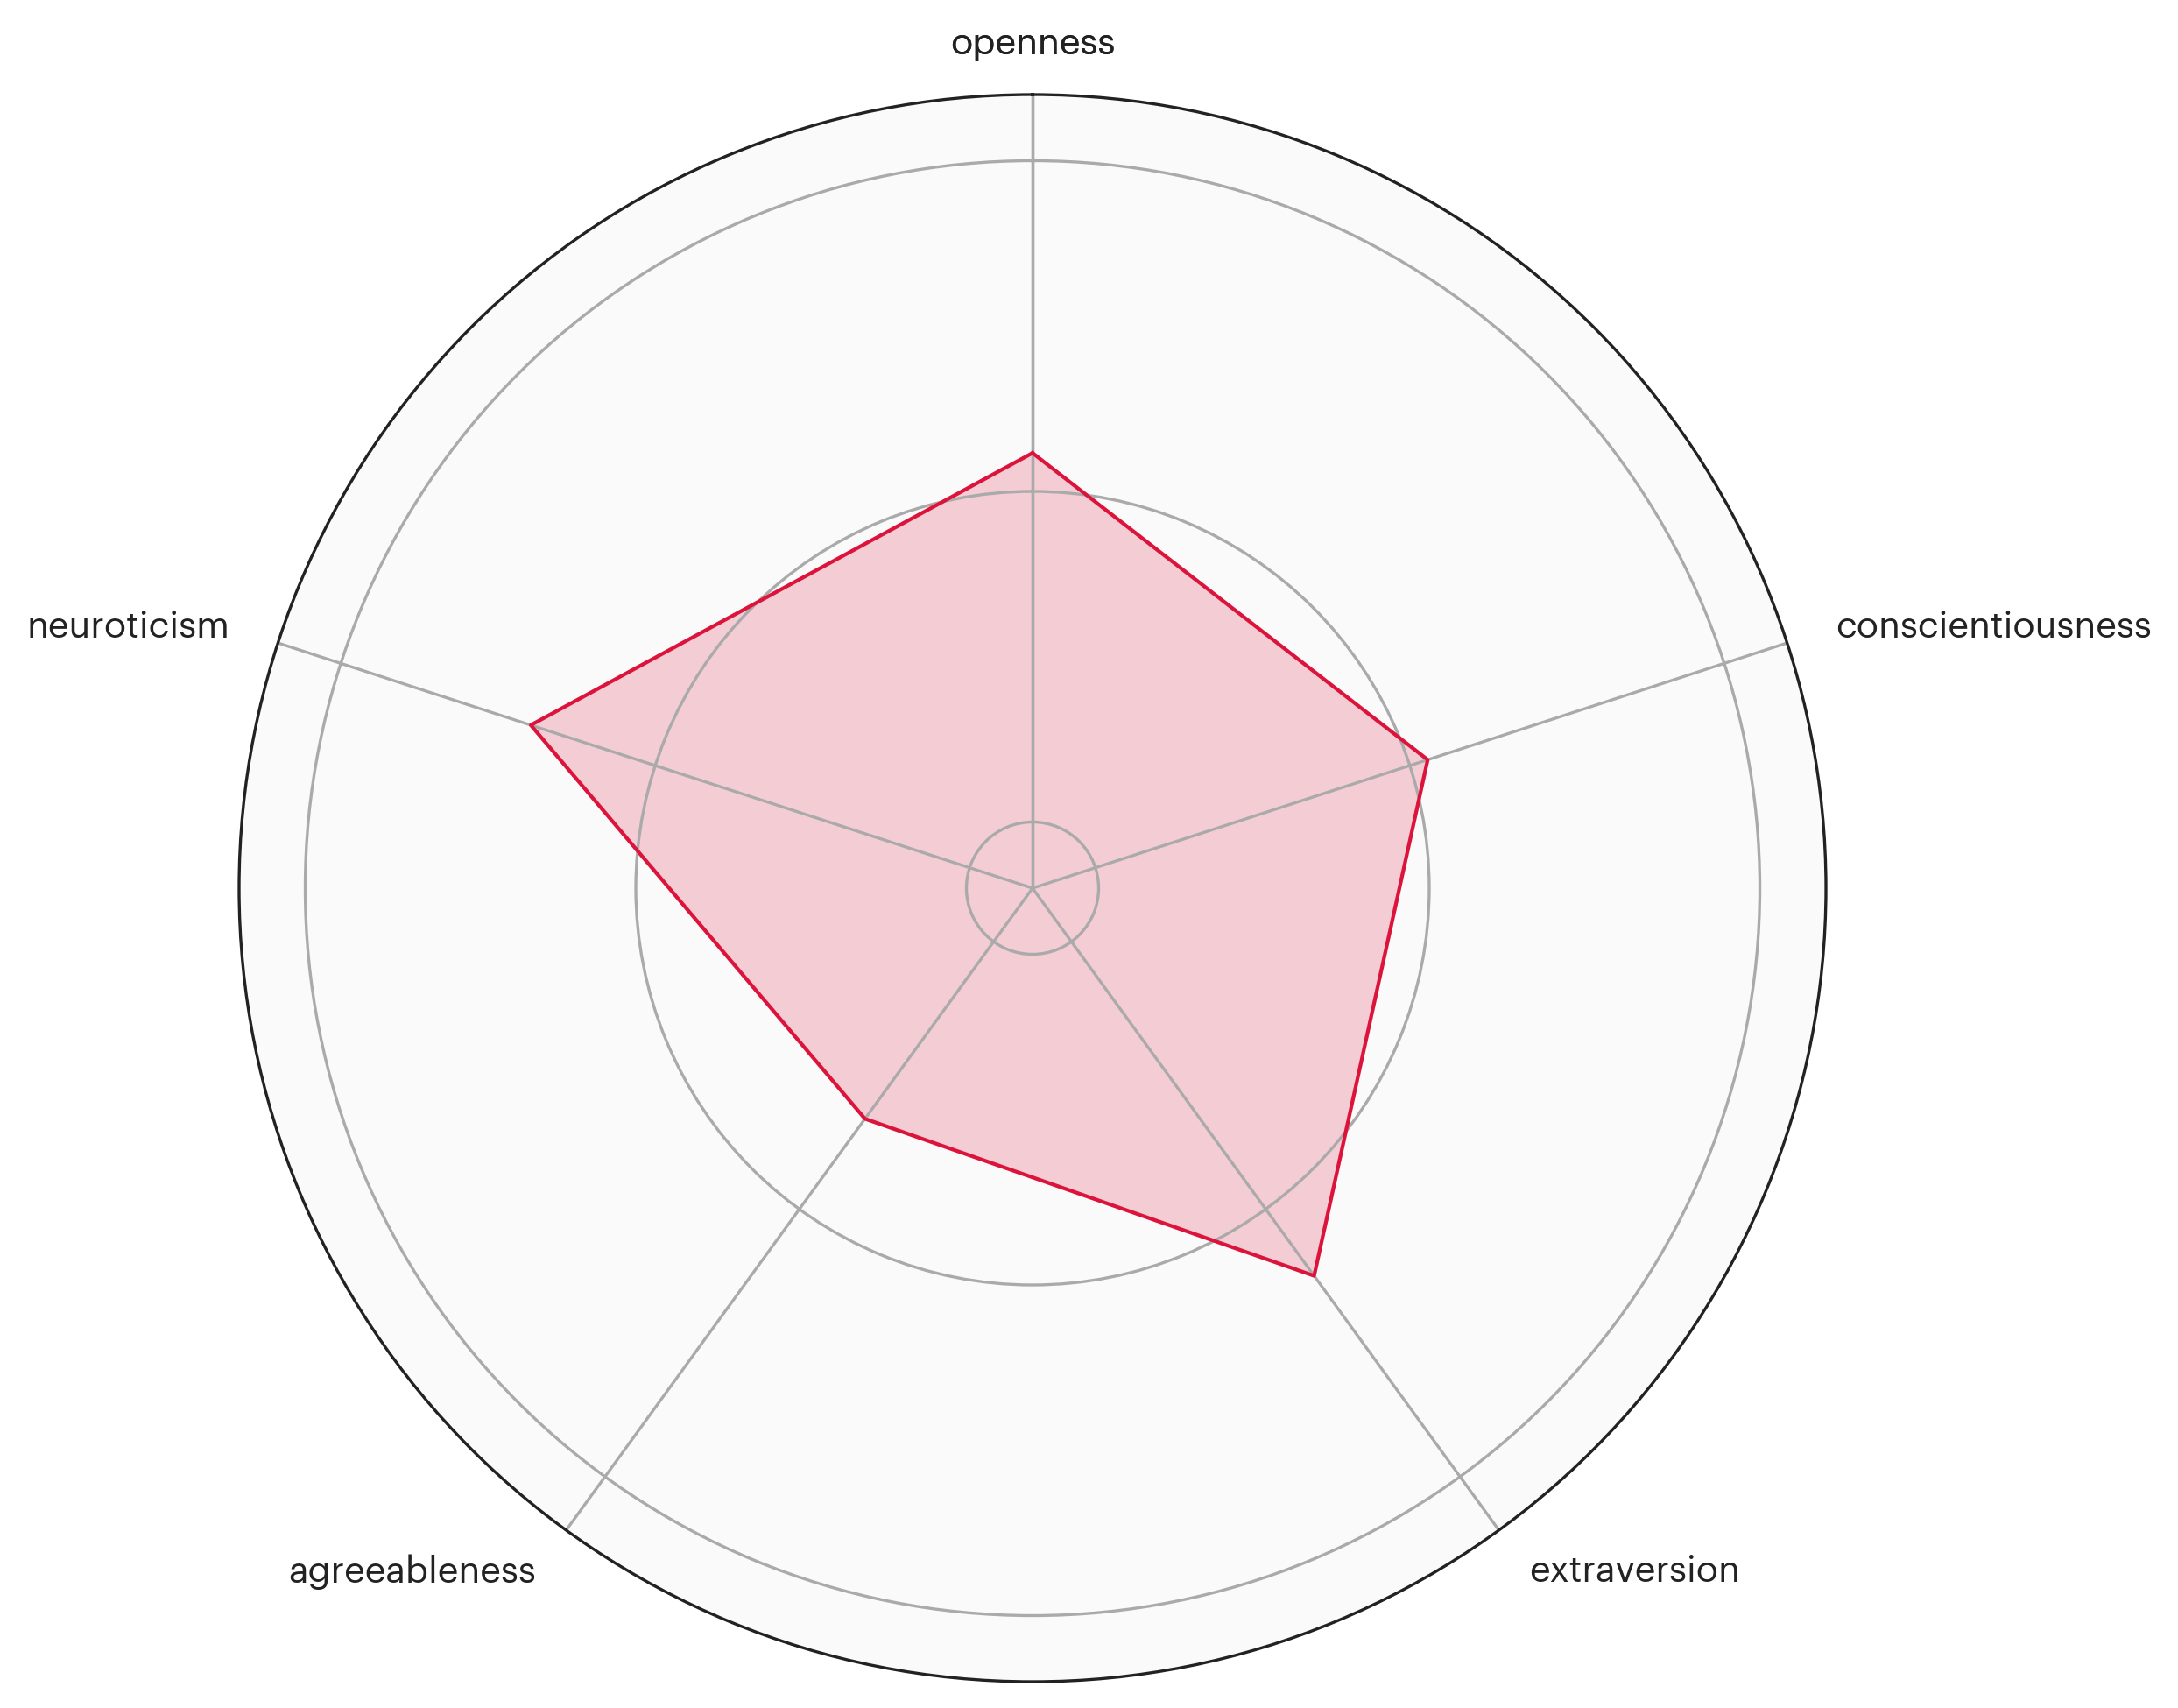

In [15]:
cw_talk2 = """ 
greetings everyone uh this is kathy wood\ncio of arc invest\nand as you know we've been doing these\nuh videos for well actually since april\nof 2020\nuh during the depths of the coronavirus\nuh and as you know since then we went\nthrough a boom in the equity markets and\nuh now we're in a bear market\nessentially certainly the nasdaq is\nuh down 20 percent or more than 20\npercent from its peak\nuh and uh i always say to my team it's\ndarkest before the dawn\nand i do think we're moving into some\ncathartic moments we're certainly seeing\nthe equity market rebel against what we\nbelieve\nis\nmonetary policy that will end up being\ntoo tight but before i go there\nas you know we go through monetary\npolicy fiscal policy economic indicators\nmarket indicators and then a little bit\non innovation and and this uh this month\nwe're featuring something called the\nbitcoin monthly um it will be hot off\nthe press soon after uh this video and\num\nit's chock full of information and\nperspective about what's going on with\nbitcoin in particular and ultimately we\nwill be rolling out to all of crypto\nassets or all of the major crypto assets\nat some point in the future but a very\ngood place to start is bitcoin of course\nuh so let's start with monetary policy\nso so in the last month uh the fed did\ntighten up\nwe are now in the fed funds range\nbetween 0.75 percent and 1\nso from basically 0 to 25\nwe have or 25 basis points uh we've now\ngone if you use the high end of that\nrange from 25 basis points to\neffectively one so up four fold and the\nreason i'm giving that as perspective is\nwe are beginning to wonder\nif one of the policy mistakes here is\nnot understanding that we're starting\nuh with interest rates at such a low\nbase that when you quadruple them\nuh or go up tenfold which uh which many\npeople think the fed will do before all\nis said and done so going from 0.25\nto\n2.5\npercent\nthat's a 225 basis point increase that's\nup 10 fold uh we've already gone up\nfourfold\nand\njust hearkening back to\nthe last time the fed was fighting\ninflation\nand uh and ferociously fighting\ninflation was under volcker in the late\n70s and the early 80s\nand uh in and i was there i was just\nstarting my career and i remember the\nfed funds rate was at 10 percent\nand uh chairman volcker at the time\njacked it up to 20\nin one move\nso\nthat was a thousand basis points to be\nsure that's a lot\nuh and he did it to shock the economy\num\nbut that was only up two-fold uh we've\nalready gone up four-fold\nand potentially up tenfold and\njust beginning to wonder if you know the\nimpact on the economy\nstarting from such a low rate\nand having been at low rates for so long\nthat maybe this is yes a shock to the\neconomy\nand we're seeing m2 growth slowing it\npeaked i think at about 27\nand is now down to eight percent on a\nyear-over-year basis but if you look at\nuh month-to-month what you'll find is\nmoney has barely grown at all\nsince january um that is very tight\npolicy already\nand\nnow we're beginning i think just\nyesterday we began something called\nquantitative tightening now i don't i\nsay we it's the fed\nstarted quantitative tightening\nand what that means is that it is going\nto let uh some of the assets on its\nbalance sheet simply roll off it's not\ngoing to\nbuy mortgage bonds or or treasury bonds\nas it has been\njust to replace those maturing\nmany people think that quantitative\ntightening is\nis is a a real tightening move\ni think i just described the tightening\nmoves the quantitative tightening is\nnothing more\nthan assets on the central bank's\nbalance sheet the fed's balance sheet\nthat are going to roll off\nthey were kindling\nfor what could have been\nan accelerated rate of bank loan growth\nbut they were never lit and so they're\nsimply going to roll off\nso we don't think that is as significant\nas the actual tightening moves uh\nas it pertains to interest rate and and\nmoney supply\nuh now one of the\nfights or the biggest fight that the fed\nhas on its hands it believes is\ninflation and inflation has been much\nhigher than we would have expected and\nyou know the reason supply chain uh\nissues for much longer almost two years\nnow more than two years now\nand then of course russia invading\nukraine\nreally driving up food and energy prices\nso\nthe fed is not happy with this and no\none's happy in fact the consumer is very\nupset hasn't been this upset since uh\n0809\nbut we are beginning to see signs that\ninflation has peaked and chairman powell\ndid say maybe it did peak in uh in march\nuh we got the personal consumption\ndeflator which is the fed's\nprimary\ninflation indicator it's the one they\npay\nuh to which they pay the most attention\nthe headline pce deflator was an\nincrease of 0.2 percent\nso that's two and a half percent at an\nannualized rate roughly uh and if we\nwere back there on a year-over-year\nbasis the fed would not be tightening uh\nnonetheless to see that happening at the\nmargin is really important and the fed\nshould start taking some comfort from it\nthe core cpi it pays more attention to\nthe core cpi was up 0.3 so that's three\nand a half percent annualized it would\nlike to get that down 2.2 as well\nbut we have seen the year-over-year\ninflation rate in core\nuh pce\ndropped from 5.3\nin february so this measure of inflation\npeaked perhaps in in february\nmarch was\nticked down to 5.2\nand\napril down to 4.9 uh and if those\nsequential numbers are any indication\nthat rate will continue to come down\nover the next year or so\nuh so\nthe other the other prices that the fed\nis watching i think um\nuh our\ncopper copper is a very good\nindicator of what's going on in the\neconomy and and that's the global\neconomy we know that europe and china\nare practically in recession if not\nabsolutely in recession\nchina's easing to try and take some of\nthe pressure off but i think oil prices\nmight be the more important price mostly\nbecause of how they impact uh consumer\nsentiment\nand inflation psychology generally\nso oil prices did kick up this last\nmonth again\nwe still didn't get back to the peak uh\nright after uh russia invaded ukraine\noil prices got into\nthe 130s\nper barrel\nand\nwe're now down to 119 but we have been\ndown below 100 very recently so it's\nkicking back up and it will\ninfluence the inflation metrics not so\nmuch the core pce because\ncore\nexcludes food and energy\nand uh this this uh metric was\ni guess it was\ndesigned or or derived in the 70s when\noil and food were very very volatile and\noften misleading in terms of where\ninflation ultimately was going to go\nso\nwe shall see what happens oil is more is\ninfluenced by a cartel\nwe do believe there's serious demand\ndestruction taking place at these price\nlevels\nyou can see around your own communities\nthere's either less traffic or that\nyou'll see more bicycles scooters and so\nforth\nand\nwe do believe and we've been saying this\nfor some time that oil demand globally\nprobably peaked in 2019\nit is the supply shock that is driving\nprices up\nand um and is also going to ex or has\naccelerated the consumer preference for\nelectric vehicles over gas-powered\nvehicles\nso we do believe that this oil price\nincrease\nis sowing the seeds of its own demise in\nthe form of demand destruction and when\nwe say oil demand peaked in 2019 we mean\nit peaked many people used to use this\nconcept peak oil\nwhen they were talking about supply\nthinking we'd run out of it\nand instead we are using it\nin the form of peak demand\nthe demand destruction and the shift\ntowards energy conservation in all kinds\nof ways\nso so that's monetary policy we think\nthe fed is probably overdoing it i think\nthat certainly in terms of its intention\nto go up\nanother two or three\n50 basis point increases\nthe markets are railing against that and\nit is perhaps because of this very low\nbase that i mentioned in the beginning\nwe've already gone up four-fold from the\nlow\nstill at a fairly low rate one percent\non the fed funds\nbut\nthe market seems to be saying that\nthis is more than just letting the\nmarkets work and letting interest rates\ngo up\nthe economy may not the global economy\nmay not be able to take too much more\non the fiscal policy side it was very\ninteresting to\nread president biden's op-ed in the wall\nstreet journal\nand his focus was inflation\ntop of mind inflation is a big deal this\nmidterm election year\nand it could\nit could make the difference between\nwinning and losing\nso his three answers to inflation\ninclude let the fed do its work now\nthat's really interesting\nas normally a democratic administration\nwould expect a little more of a dovish\nfed they'd be arguing for less restraint\nbut he's saying let the fed work and so\num i guess that's\nthe fed is an independent uh\nuh body so\nthe president doesn't shouldn't have any\ninfluence over what they do but it is\ninteresting in an election year to have\nthe president saying let the fed do its\nthing keep those interest rates going up\nthe second is\npull the deficit down the government\ndeficit down\nthat would be more of a republican\nargument so again a surprise\nand\nhe\nhas suggested ways to get it down that\ninclude tax increases\nwe do not believe any of these will go\nthrough this year this is a midterm\nelection year it's going to get it's\ngoing to be very difficult to get a\nagreement\non tax increases this close to the\nmidterm elections\nand then the other\nideas he has include and this is\npredictable\ntrying to\nwhittle down health care costs\nespecially for medicare\nthat has been a weight on health care\nstocks recently\nincluding the genomic stocks\nwhich again if genomics uh companies can\nevolve cures\nthat should save a lot of money but it\njust won't be this year it'll be over\nthe long term\nand then he also is suggesting investing\nin new energy and so forth again that's\na longer term\nsolution so nothing really is going to\ncome out of that for this year\nso\nin terms of the\nmidterm elections one of the things that\nis happening here is investors are\nbeginning to think about\na shift to a republican house and maybe\na republican senate\nbecause of how badly things have gone\nin this this year\nand\none of the things we're hearing is that\nthere will be\nless pressure\non on technology and and maybe more of\nmovement towards it for example\ntelemedicine in in medicare\nthat's a great way to reduce costs and\nso\nuh we believe that the telemedicine\ncompanies are probably going to be\nbenefited by a shift if there is a shift\nuh towards uh\nrepublican wins in the the house and the\nsenate\nokay on to the economy well we've had\nsome very interesting comments on the\neconomy by business leaders\njust\nyesterday i believe elon musk said\nthat he has a super bad feeling\nabout the economy\nand we're trying to figure out\nwhat he's looking at\nwe know his own sales\nwere up tesla sales in the month of may\nuh i believe were up globally 60 percent\nand almost every other auto manufacturer\nsales were down and some of them down by\na lot\num so it's not his own sales except\nperhaps at the margin maybe something\nthat he's seeing in orders\num\nhe may be reflecting on the decline in\ntotal auto sales\num and uh so that's interesting uh jamie\ndimon at jp morgan\nuh talked about a hurricane be prepared\nfor a hurricane he doesn't know what\nkind of hurricane is it going to be a\nmild one or is it going to be a\nhurricane sandy which would be\nquite serious um but\nuh i think he's changed his tune a bit\nin in the last month since uh since jp\nmorgan reported earnings so what what is\nhe saying well he sees a lot of business\nactivity and must see it slowing down if\ni if i had to guess\nand um the president of goldman\nuh described this environment as a\nconfluence of shocks that in his career\nhas been unprecedented so again he has a\nvery good perspective a global\nperspective\nevery sector and so i would say at the\nmargin these three business leaders are\nseeing uh the economy in in some\nin some form of stress\nnow one of uh one of the\nissues we've been focused on with you on\non this video\nis the inventory buildup that was likely\nand we had been saying that through the\nlast year\nand um it took a while to uh to get\nthrough some\nsome of the supply chain issues but now\nwe are seeing inventory increases the\nlikes of which i have never seen in my\ncareer\nand i'm talking about on a company by\ncompany basis\nso walmart\nuh as as i'm as nancy and i mentioned in\nthis last youtube video\nuh walmart sales up uh three percent on\na comparable store basis year over year\nwhich means they were probably down in\nunit terms\ninventory is up 33 percent which\nprobably means in real terms taking away\ninflation they were up 25\nto 30 percent\nwell that's interesting because more\nthan half of walmart's\nsales\nare in the groceries are in groceries\nand you're not going to see huge\ninventory buildups in groceries and so\nwhat does this say for the other half\nare their inventories up 80 percent\nuh you know it's it's kind of crazy to\nthink that that's a possibility but it's\na possibility\nand target targets inventories we're up\n42 now it has less in the way of\ngroceries as a share of the total uh so\n42 percent uh maybe if you x groceries\nwas up 50 to 60 percent um\nthese are crazy numbers for two of the\nbest managed companies from a supply\nchain management point of view in the\nworld\nuh and so maybe\nuh maybe a jamie dimon is starting to\nsee this backing up in other ways\num in in in terms of the way the\ninformation he has\nuh another very interesting\num\nstory recently this was in the wall\nstreet journal\nwas one of the big amazon seller\naggregators so um\nbasically pulling together a bunch of\nsmaller sellers and\nand aggregating them uh onto the amazon\nnetwork from a third party point of view\nin january of this year the this\naggregator\nhad uh it had planned to go public uh it\nhad such a boom\nbooming conditions during covid\nuh that it had um it felt that you know\nthis was a shift that would continue and\nthat it could go public and wanted to go\npublic in order to continue uh to\naggregate the seller ecosystem uh for\namazon\nwell um he instead of going public the\nceo uh decided the marking conditions\nwere a little hostiles but he still went\nahead with the party he had planned in\njanuary\nand so brought a bunch of the sellers\ndown to mexico\nand\ni guess they were feeling very confident\nin january\nwell guess what\njust recently that ceo was let go\nthey will not go public and they may be\nin trouble and they may be in too much\ndebt uh again so much confidence during\ncovet that you know\nhis business would continue to boom so\neven the amazon seller ecosystem and\nthese are third-party sellers which are\nmore than half of all of amazon sales\neven they are having problem after years\nof taking massive share from\nthe brick and mortar retailers\nso just thought that was an interesting\nstory and\nsurprisingly\nauto sales\nnow\nthe auto manufacturers\nfinally are getting through supply chain\nissues\nand according to wards\ntheir plans were to increase production\nor they're in the midst of increasing\nproduction to something by something\nlike 20 this quarter\num and uh\nand what we got this week was kind of\nsurprising uh auto sales dropped back\ndown\nuh from 14.\nmillion now steady state is 17 million\nso they had not even gotten back to st\nsteady state which is uh 17 to 18\nmillion um and that's an annualized\nunit rate\nper year for the us\nso uh 14.3 and the expectation was that\nthat would just continue on up to a more\nnormal normalized rate well instead in\nuh in may it appears\nuh auto sales dropped 12.7 so here we\nare again if they build the inventory\nand the consumer does not come in fact\nthe consumer retrenches uh these\ncompanies are going to have too much\ninventory uh what a surprise given all\nthe supply chain issues we've been\nhearing about\nnow today is employment friday this is\nwhy we do um this video on this friday\nthere's a lot of information in the\nemployment report so today's employment\nreport the non-farm payroll was a little\nstronger than expected an increase of\n390 000\nin non-farm payroll\njobs and um\nif we're right uh then\nthe uh the\nemployment gains should be slowing down\nquite dramatically here uh and um and\nthey are slowing down they're not in the\n500 to 800\n000 range per month they are down below\n400 000 now and we think they'll\ncontinue to move down if not negative uh\nby the end of this year\nuh but they are stronger than i i would\nhave expected and as we've mentioned\nhere before\none of the possibilities might be so\nmany\nuh\nso many employers had been experiencing\nwork shortages labor shortages\nthat now\nthat they're able to get the labor\nthey're saying okay even though my\nbusiness is slowing down i want to make\nsure i'm ready for the next cycle so\nthat could be what's going on\nwhat's interesting is average hourly\nearnings again another very important\ninflation indicator\naverage uh\nhourly earnings\nare up\nwere up 0.3 percent in this last month\nexpectations uh 0.4\nso the year-over-year rate has gone from\n5.5 percent to 5.2 percent\nuh so again this should um assuage the\nthe fed's concerns\nthat we're moving into a wage price\nspiral um the the inflation rates that\nwe've seen in the last year do not seem\nto be getting into uh into wages in a\npermanent way what we did see for a\nwhile there were\nbecause of the labor shortages wages\ngoing up to to bring people out of their\nhomes\nafter covid uh and back into the labor\nforce the labor force participation rate\ndid tick up uh a bit after falling the\nprevious month the only the only um\nthe only variables in the report that i\ndon't think got enough attention by the\npress and and economists out there uh\nreally there are two uh in the\nmanufacturing sector the the\nnumber of uh the gain in employment was\nabout half that expected 18 000 i think\n39 000 was expected the other thing that\ndid not get i didn't see any mention was\nthe work week the average work week in\nthe manufacturing sector went down and\novertime went down so i think this is\nthe first indication uh that we're\nseeing that inventories are piling up\nand\nand\nthe manufacturing sector is beginning to\nretrench the other thing we saw and this\nmakes sense given what i just mentioned\nabout walmart and target is the number\nof retail jobs dropped by 61 000 that's\na pretty big drop\nand then\nusing nancy lazar's so piper piper\nsandler's numbers\nthey are tallying up the number of\nhiring freezes and layoffs companies are\nannouncing\nand in total\nsince february 61 companies this is u.s\nbased have announced freezes or\nor layoffs and just yesterday\nas uh you probably know uh tesla said\nthat it was going to lay off 10\nof its workforce today uh it clarified\nthat it's not the manufacturing part of\nthe uh labor force it is the white\ncollar so uh that's that's pretty\ninteresting as well now the consumption\nindicators that have come out over the\nlast month are quite confusing um and\nwe've given you some of the micro with\nwalmart and and and target and amazon uh\nif you look at the macro numbers that\ncame out uh personal consumption\nexpenditures for\napril uh came out at\n0.9\nthat's that's nominal so that includes\ninflation excluding inflation 0.7\npercent uh so that was a pretty strong\nreport after after a a a great degree of\nsluggishness the reason it's surprising\nis we also got the university of\nmichigan's consumer sentiment index\nand it fell it fell to a new low\nand we're back to where we were in 0809\nuh so that is not a good place and and\nit's hard to understand why consumers\nwould be spending so much uh the other\nthe other confusing statistic to me is\nconsumer credit the change in consumer\ncredit outstanding\nnow this includes both revolving so\ncredit cards and installment debt\nand these are huge numbers for march and\napril 37 billion and 52 billion normally\nwe're used to seeing 6 billion or 5\nbillion now i have seen this before at\nturning points in the cycle when\nconsumers or small businesses probably\nmore the latter\nbut applying as consumers\nthey are worried about their ability to\nget credit in the future so they take\ndown their credit lines and\nwe're wondering if that's part of what's\ngoing on right now the other\npuzzle here is the consumer saving rate\nwhich uh peaked at i believe 34\nin april or may of 2020\nuh dropped was and has been revised down\nand and it has dropped to 4.4 percent\nso pre-covered we were at 8\nwe're down to 4.4 percent and we haven't\nseen that level since 08 right around\nthe time lehman uh went bankrupt uh so\n\nit's confusing uh\nthe combination of sentiment and savings\nlow savings very low sentiment\num the consumer would not seem to be in\na spending mood\nso we shall see you know these\nstatistics are often revised one month\ndoes not a trend make either\nbut that is a bit of a disconnect for us\nwe're also seeing housing all kinds of\nhousing metrics going south now\naffordability has collapsed a\ncombination of\na significant increase in mortgage rates\nand pricing is pricing consumers out of\nthe market and consumer sentiment i'm\nsure\nis not helping the situation i mentioned\nauto so you've got housing and autos two\nof the most cyclical parts of the\neconomy uh going down right now the um\nthe uh used car sales\nuh i i should also mention are down\nabout 20 year-over-year now we're seeing\nnew new car sales down\nsequentially and they're down also also\nmore than 20 on a year-over-year basis\nthese are these are big declines uh so\nwe think that's going to start backing\nup\ninto the price of used cars which will\nthen in turn back up\ninto the secured uh the secured credit\nuh um\ninstruments out there backed by\nuh used cars uh\nthe residual value of used cars and new\ncars will be going down if uh if we're\nright and and the economy is as weak as\nthese sectors are suggesting\num\nand now on to uh markets what are the\nmarkets telling us equities are telling\nus um\nthat the the fed is going to make a\nmistake and even the fed is saying we\ncould make a mistake the economy could\nenter into recession we hope not there\nthere are instances of so-called soft\nlandings uh but i would submit that\nhousing and autos down 20\nis not a soft landing uh you're seeing\nin the in the um sectors\nas equities are broken out by something\ncalled gex\nsectors\num energy energy utilities and materials\nare up now energy and materials are\nvalue\nsectors\nand\nthey tend to do well in inflationary\ntimes if we're right and fiscal\nfiscal and monetary policy are are both\nvery tight and and getting tighter\nuh then\nat some point this is going to flip we\nwill flip away from these this value\nrotation\nand back to growth and it couldn't\nhappen too soon for us of course\nuh on the um on the losing side consumer\ndiscretionary and of course the\nthe um\nany advertising sensitive company is\ngetting hit here especially on the\nsocial side and especially with the the\ncompetition from uh tick tock so it's\nhard to tell how much of this is a\ncompetitive dynamic and how much of it\nis an economic dynamic it's probably\nboth\nand of course technology has been an\nunderperformer\ninterest rates uh interestingly as the\nfed has\ntalked in a very hawkish way meaning it\nwill continue to tighten\nthe long-term treasury\nyield has had trouble\nuh\ngetting and staying above three percent\nnow\nin my mind three percent uh treasury\nyield\nwould be consistent see this is the\n10-year treasury bond yield\nit would be consistent with\n10 years of three to four percent\nnominal gdp growth on average so right\nthere\nunless the economy is negative\nuh it's\nvery unlikely meaning economic growth\nreal economic growth is negative it's\nvery unlikely that inflation is going to\nbe in the three to four percent range um\nso that should be reassuring to the fed\nand and the and the um yield curve\nmeaning the difference between long-term\ntreasury yields and short-term uh\ntreasury yields um that has flattened\ndramatically in other words as short\nrates have gone up following the fed and\nanticipating the fed if we're thinking\nabout the two-year rate\num the 10-year rate has not gone up that\nmuch uh and and so the yield curve has\nflattened to roughly 30 basis points or\n0.3 percent that's a very flat curve and\nit is typically associated either\nwith\ndisappointing growth\nimpending or\nuh lower than expected inflation or both\nuh and we think uh it will be both uh\nand we do believe that the fed in these\nnext few months is going to get the\nmessage loud and clear that it cannot\nincrease interest rates much more than\nit already has\nwe probably will see the other\n50 basis points here in june\nbut by july as companies are reporting\nearnings and talking about the future uh\nwe think the fed will get the message\nand this will be very positive for the\nequity markets and this is what we're\nwaiting for as i always say dark is\nbefore the dawn we've we're in the bear\nmarket uh everybody knows what the\nproblems are\nand um we're beginning to get signals\nfrom the marketplace that the fed um is\nuh is probably going to at least start\ntalking in a more dovish way\nas opposed to hawkish um\nwe we see the dollar and um\njunk bonds and credit default swaps uh\nall of them kind of swinging wildly in\nin the last month not giving us any\nsense of direction\nuh\nwe've seen uh commodity prices that i\nmentioned oil going back up but not\ngetting back to where we were when\nrussia invaded ukraine remember at that\ntime many people were expecting uh they\nwere expecting oil prices to go to two\nhundred dollars a barrel uh based on\nthat supply shock and that did not\nhappen uh so we're we're waiting here i\ni i often use the word wiley coyote or\nthe the idea of wiley coyote you know\nrunning running running and running off\nthe cliff not realizing it until he\nlooks down and then boom\nthis reminds me very much of 1986 yes i\ndid say 1986 oil prices were stubborn\nstubborn stubborn levitating and you\nknow the cartel even had more power back\nthen\num and it levitated until it was clear\nthat demand destruction uh was not going\nto allow uh for the pumping of oil at\nthe rate uh opec and others were pumping\nit i think the same thing's going to\nhappen now especially uh now that the us\nu.s\nor oil producers can\nhide behind uh national security as they\nare starting to\nuh pump more oil i think next year\nwithin the next year we'll be up to an\nall-time high in oil production again\nand will will be perhaps perhaps will be\nthe largest producer in the world once\nagain\num now one of i'd like to conclude this\nis this is bleeding now into the\ninnovation part of\nuh this video um i'd like to talk about\nbitcoin as i mentioned uh we're\nwe're launching the bitcoin monthly um\nand uh\nvery excited about it uh because we\nthink the market needs this\num\nand\nyasin almandra who's our lead crypto\nanalyst leading our crypto effort\nand david powell most many of you may\nknow him uh from his on-chain\nanalytics work\nhe's created\nmany metrics that\nmany people are using these days so\nwe're so happy to have him on board as\nwell\nwell\nin this report you will see that\nfor the first time in bitcoin's history\nwe've seen nine consecutive weekly\ndeclines\nand so when we first looked at that\nuh i think that the tendency was to say\nuh oh that's really negative\num and\nmy question to the team was well could\nit be oversold\nuh could the rubber band be stretching\nhere\nor or is there something uh or is there\nsomething wrong\nand we don't know the answer to that so\nwe put that in neutral category and\nyou'll see we'll put each of these\nmetrics in bullish bearish or neutral\nbut we do know what happened in the last\nmonth is that\nterra the blockchain terror blew up\nuh\nand luna is worthless\nuh i think uh i i think i'm correct in\nsaying that uh that the market cap of\nthat ecosystem at one point was around\n60 billion dollars\nwith a lot of um\na lot of well-known advocates for it uh\ni was surprised because\num\nalgorithmic stable coins uh don't make\nany sense to me i have a background in\neconomics and uh\nyou know i i i think you need the\nbacking of something uh in order to have\na stable coin uh and uh this did not\nand so\ni it didn't surprise me to see the\nnumber i think this is the number of\nluna uh outstanding go from\nin in the span of a week something like\n350 million to six and a half trillion\nand i i think it maybe even got to 20\ntrillion so that's hyperinflation\nthere was nothing backing it and uh\ni can say we would never have touched it\num\nnonetheless nonetheless\nuh that turmoil that it didn't create a\nsystemic risk\num\nand we've been paying attention to the\nother stable coins out there are they\ngoing to so-called break the buck so\nthat expression came about after the\nreserve fund a money market fund during\n0.009 broke the buck\npeople holding that money market fund\nwere going to get less than a dollar\nback for every dollar they put in and of\ncourse the fed had to come and rescue\nuh that that fund because that was going\nto become systemic um in the 0809\nmeltdown\num but\nthe just the idea that such\nsuch an instrument could exist has\nprobably given the fed more ammunition\nnot the fed the regulators more\nammunition\nto regulate in this space\nand\nand the fed could be involved in in the\nregulation um there were was about three\nbillion dollars of bitcoin uh used as\ncollateral they had been building uh\nbuilding it up in the last month or so\nand so we believe all of that was\ndisgorged at one point that's one reason\nuh that the bitcoin has gone down from\nuh for in the last month just from forty\nthousand to thirty thousand uh another\nreason is the high correlation with the\nnasdaq now interestingly in the last\nweek or so that correlation broke down a\nbit the nasdaq had a few really good\ndays uh bitcoin did not so there's\nsomething else bothering uh bothering\nbitcoin it is down 57 since it's high at\nalmost 70 000\nin in november\nuh its 200 week moving average is 22\n000. so today we're at 29 000 i think\nit's 200 week moving average is at uh 22\n000 and rising now the reason that\nparticular number is interesting to us\nis\nwe initiated our first bitcoin uh\nposition\nat uh back then it was the 200 week\nmoving average it was in the\n225 to 250 dollar range so we've come a\nlong way since then uh but that has\nproven to be a a a nice support\num\nso that's that's also interesting a\ncouple of other points i'll just\nhighlight and you can see in the report\nit appears that the term holders\nand you can see everything in this\necosystem the transparency is amazing\nthis does appear according to our\nmetrics that\nshort-term holders have capitulated\nthat's very good news in terms of\nputting in a bottom\nlong-term holders are at an all-time\nhigh at 65.7 percent\nuh that means they've been holding\nbitcoin for at least a year that is that\nwe've got some very strong holders our\nhodlers here uh that's also very good\nnews uh although we might see some\nlong-term holder capitulation to to mark\nthe bottom\num and then the last metric that i'll\nfeature there are many more is that uh\nthe futures bitcoin futures are selling\nat a discount discount to the to to to\nspot bitcoin\nand\nduring those times we expect volatility\nnow we don't know if it's up or down but\nyou can see from other metrics\nuh in in the piece that our uh our\n\nthinking right now or our judgment call\nis the next big bout of volatility in\nbitcoin will be to the upside\nnonetheless we are on guard uh you know\nthe the terra\nuh\nthe terra\num\ndisaster it was a fiasco for for crypto\ni think in terms of raising\num or giving regulators even more\nincentive and reason to come in and\nregulate a little bit more\nwith more of a heavy hand than we would\nanticipate uh so take a look at the\nreport uh it will be coming out monthly\nuh there'll be a little summary of what\nwe think are uh the most important um\ndevelopments during the past month\nand um you know again bitcoin blockchain\ntechnology is very transparent uh arc\ninvest is very transparent and uh\nwe will be out there um you know giving\nyou our point of view uh and and\nexplaining you know what we believe is\ngoing on every step of the way we give\nour research away so you understand why\nwe're invested how we're invested we\nwill be um putting up in uh in the next\n10 days another of our models we're open\nsourcing another model uh so stay tuned\nfor that\nwe intend to model certainly our top ten\nstocks over time and put those models on\ngithub\nso that you will be able to uh if you\ndisagree with our assumptions modify\nthem\nand and get a sense of where uh the\nprice target would be five years out if\nyour assumptions are correct and another\nreason we're putting these models out\nis because we feel that they're not\nbeing the these stocks are not being\ncovered as effectively as they might be\nall we do is disruptive innovation all\nof our investing and research is\ncentered on it\nand so we want to offer it up to help\nenlighten people who might like to know\nuh how we think the world is changing we\ncertainly put a lot of the top-down work\nout there now we're putting out more of\nthe bottom-up work so you can see uh the\nintensity behind our analysis not just\nthe top-down analysis but the bottom-up\nanalysis\nand you can also see and this is so\nimportant how taking a five-year point\nof view\num can change uh completely\nthe outlook for a stock when we're in\nrisk off everyone's time horizon shrinks\nto almost nothing\nand uh\nif it's almost like they focus on the\nlast 12 months\nbut when risk on happens again time\nhorizons will extend\nand uh and we hope that we will be\nproviding you uh with a better\nunderstanding of how the next five years\nare going to look for uh for lots of\nstocks\nuh and and of course for our five\ninnovation platforms so genomic\nsequencing adaptive robotics energy\nstorage artificial intelligence and\nblockchain technology so with that um\ni will look forward to\nuh presenting again next month and\nhopefully these cathartic moments have\nhappened and we'll be on our way again\nso thanks again\n
""" # "Inventories & Deflation", https://www.youtube.com/watch?v=X2N-mE9HqS0&t=1s

cw_t2 = organize_personality_results( classify(cw_talk2, traits) ) 

plot_personality_traits_for(cw_t2)

<br>Capture personality traits for each talk in the dataset

In [ ]:
records = project.sql_query(""" 
    SELECT * FROM talks
    WHERE
        transcript    IS NOT NULL AND
        annotations_p IS     NULL
    ORDER BY slug ASC;
"""); lr = len(records)

if lr > 0 : df = project.create_dataframe_from(records)
    
for _,row in tqdm( list(df.iterrows()) ): 
    
    results = organize_personality_results(
        classifier(row["transcript"], traits, multi_label=True), put=False
    )
    
    project.sql_commit("UPDATE talks SET annotations_p='{0}' WHERE slug='{1}'".format(
        json.dumps(results), row["slug"])
    )

<br><br>